<a href="https://colab.research.google.com/github/RobbieEarle/high_ord_actfun_experiments/blob/main/higher_order_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
from google.colab.output import eval_js
import os
import sys
import copy

drive.mount('/content/drive')
if os.getcwd() != '/content/drive/My Drive/Research_2021':
  %cd drive/MyDrive/
  if not os.path.isdir('Research_2021'):
    %mkdir 'Research_2021'
  %cd Research_2021
if not os.path.isdir('Visualization'):
  !git clone https://github.com/jzliu-100/visualize-neural-network.git
  os.rename('visualize-neural-network', 'Visualization')

if '/content/drive/My Drive/Research_2021' not in sys.path:
  sys.path.append('/content/drive/My Drive/Research_2021')

from Visualization import VisualizeNN as VisNN
import matplotlib.pyplot as plt
import seaborn as sns

Mounted at /content/drive
/content/drive/MyDrive
/content/drive/MyDrive/Research_2021


## Setup

#### Activation Functions

In [2]:
import torch
import torch.utils.data
import torch.nn as nn
import math
import numpy as np
import torch.nn.functional as F

_ACTFUNS = {
    'ail_and':
        lambda z: logistic_and_approx(z),
    'ail_or':
        lambda z: logistic_or_approx(z),
    'ail_xnor':
        lambda z: logistic_xnor_approx(z),
    'relu':
        lambda z: F.relu_(z),
    'tanh':
        lambda z: F.tanh(z),
    'leaky_relu':
        lambda z: F.leaky_relu_(z),
    'abs':
        lambda z: torch.abs_(z),
    'swish':
        lambda z: z * torch.sigmoid(z),
    'prod':
        lambda z: torch.prod(z, dim=2),
    'max':
        lambda z: torch.max(z, dim=2).values,
    'min':
        lambda z: torch.min(z, dim=2).values,
    'signed_geomean':
        lambda z: sgm(z),
    'swishk':
        lambda z: z[:, :, 0] * torch.exp(torch.sum(F.logsigmoid(z), dim=2)),
    'swishy':
        lambda z: z[:, :, 0] * torch.exp(torch.sum(F.logsigmoid(z[:, :, 1:]), dim=2)),
    'l1':
        lambda z: (torch.sum(z.abs(), dim=2)),
    'l2':
        lambda z: (torch.sum(z.pow(2), dim=2)).sqrt_(),
    'l3-signed':
        lambda z: signed_l3(z),
    'linf':
        lambda z: torch.max(z.abs(), dim=2).values,
    'lse':
        lambda z: torch.logsumexp(z, dim=2),
    'lae':
        lambda z: logavgexp(z, dim=2),
    'nlsen':
        lambda z: -1 * torch.logsumexp(-1 * z, dim=2),
    'nlaen':
        lambda z: -1 * logavgexp(-1 * z, dim=2),
    'lse-approx':
        lambda z: torch.max(z[:, :, 0], z[:, :, 1]) + torch.max(torch.tensor(0., device=z.device), _ln2 - 0.305 * (z[:, :, 0] - z[:, :, 1]).abs_()),
    'lae-approx':
        lambda z: torch.max(z[:, :, 0], z[:, :, 1]) + torch.max(torch.tensor(-_ln2, device=z.device), -0.305 * (z[:, :, 0] - z[:, :, 1]).abs_()),
    'nlsen-approx':
        lambda z: -torch.max(-z[:, :, 0], -z[:, :, 1]) - torch.max(torch.tensor(0., device=z.device), _ln2 - 0.305 * (z[:, :, 0] - z[:, :, 1]).abs_()),
    'nlaen-approx':
        lambda z: -torch.max(-z[:, :, 0], -z[:, :, 1]) - torch.max(torch.tensor(-_ln2, device=z.device), -0.305 * (z[:, :, 0] - z[:, :, 1]).abs_()),
    'multi_relu':
        lambda z: multi_relu(z),
}
_ln2 = 0.6931471805599453

def logistic_and_approx(z):
  return torch.where(
    (z < 0).all(dim=2),
    z.sum(dim=2),
    torch.min(z, dim=2).values,
  )


def logistic_or_approx(z):
  return torch.where(
    (z > 0).all(dim=2),
    z.sum(dim=2),
    torch.max(z, dim=2).values,
  )

def logistic_xnor_approx(z):
  z = z.unsqueeze(1) if len(z.shape) != 3 else z
  return torch.sign(torch.prod(z, dim=2)) * torch.min(z.abs(), dim=2).values

class SignedGeomean(torch.autograd.Function):
  @staticmethod
  def forward(ctx, input):
    ctx.save_for_backward(input)
    prod = torch.prod(input, dim=2)
    signs = prod.sign()
    return signs * prod.abs().sqrt()

  @staticmethod
  def backward(ctx, grad_output):
    input, = ctx.saved_tensors

    prod = input.prod(dim=2).unsqueeze(2)
    signs = prod.sign()

    A = (prod.expand(input.shape) / input).abs().sqrt() * input
    B = 2 * input.abs().pow(3 / 2)

    grad_input = signs * A / B * grad_output.unsqueeze(2).expand(input.shape)
    grad_input[input.abs() == 0] = 0

    return grad_input
sgm = SignedGeomean.apply

def signed_l3(z):
  x3 = z[:, :, 0].pow(3)
  y3 = z[:, :, 1].pow(3)
  out_val = (x3 + y3).tanh() * (x3 + y3).abs().pow(1 / 3)
  return out_val

def logavgexp(input, dim, keepdim=False, temperature=None, dtype=torch.float32):
  if isinstance(temperature, numbers.Number) and temperature == 1:
    temperature = None
  input_dtype = input.dtype
  if dtype is not None:
    input = input.to(dtype)
  if isinstance(temperature, torch.Tensor):
    temperature = temperature.to(input.dtype)
  if temperature is not None:
    input = input.div(temperature)
  log_n = math.log(input.shape[dim])
  lae = logsumexp(input, dim=dim, keepdim=True).sub(log_n)
  if temperature is not None:
    lae = lae.mul(temperature)
  if not keepdim:
    lae = lae.squeeze(dim)
  return lae.to(input_dtype)

def combinact(x, p, layer_type='linear', alpha_primes=None, alpha_dist=None, reduce_actfuns=False):
  if reduce_actfuns:
    all_actfuns = _COMBINACT_ACTFUNS_REDUCED
  else:
    all_actfuns = _COMBINACT_ACTFUNS

  # Recording current input shape
  batch_size = x.shape[0]
  num_clusters = x.shape[1]
  img_size = x.shape[-1]

  # print(alpha_primes.shape)
  layer_alphas = F.softmax(alpha_primes, dim=1)  # Convert alpha prime to alpha

  # Computing all activation functions
  outputs = None
  for i, actfun in enumerate(all_actfuns):
    if i == 0:
      outputs = _ACTFUNS[actfun](x).to(x.device)
      outputs = outputs.unsqueeze(dim=2)
    else:
      outputs = torch.cat((outputs, _ACTFUNS[actfun](x).unsqueeze(dim=2)), dim=2)

  # Handling per-permutation alpha vector
  if alpha_dist == "per_perm":
    if layer_type == 'conv':
      layer_alphas = layer_alphas.reshape([1, 1,
                                            layer_alphas.shape[0], layer_alphas.shape[1],
                                            1, 1])
      outputs = outputs.reshape([batch_size, int(num_clusters / p), p,
                                  len(all_actfuns), img_size, img_size])
    elif layer_type == 'linear':
      layer_alphas = layer_alphas.reshape([1, 1,
                                            layer_alphas.shape[0], layer_alphas.shape[1]])
      outputs = outputs.reshape([batch_size, int(num_clusters / p), p,
                                  len(all_actfuns)])
    outputs = outputs * layer_alphas  # Multiply elements in last 2 dims of outputs by layer_alphas
    outputs = torch.sum(outputs, dim=3)  # Sum across all actfuns

    if layer_type == 'conv':
      outputs = outputs.reshape([batch_size, num_clusters, img_size, img_size])
    elif layer_type == 'linear':
      outputs = outputs.reshape([batch_size, num_clusters])

  # Handling per-cluster alpha vector
  elif alpha_dist == "per_cluster":
    if layer_type == 'conv':
      layer_alphas = layer_alphas.reshape([1,
                                            layer_alphas.shape[0], layer_alphas.shape[1],
                                            1, 1])
    elif layer_type == 'linear':
      layer_alphas = layer_alphas.reshape([1,
                                            layer_alphas.shape[0], layer_alphas.shape[1]])
    outputs = outputs * layer_alphas  # Multiply elements in last 2 dims of outputs by layer_alphas
    outputs = torch.sum(outputs, dim=2)  # Sum across all actfuns

  return outputs


#### MLP Definition

In [3]:
class MLP(nn.Module):
  def __init__(self, net_shape, actfun, k=2, p=1, g=1, verbose=True, bn=True):
    super(MLP, self).__init__()

    self.actfun = actfun
    self.net_shape = net_shape
    self.bn = bn
    self.p, self.k, self.g = p, k, g

    if actfun == 'relu' or actfun =='swish':
      assert k==1, "k must be 1 for the {} activation function".format(actfun)

    pk_ratio = p / k
    if actfun in ['ail_all_or_xnor', 'ail_all_or_and', 'bin_all_max_min']:
      pk_ratio *= 2
    elif actfun in ['ail_all_or_and_xnor']:
      pk_ratio *= 3

    for i, layer_shape in enumerate(self.net_shape):
      if i != 0 and i != len(net_shape) - 1:
        self.net_shape[i] = self.k * self.g * int(layer_shape / (self.k * self.g))
    
    self.linear_layers = nn.ModuleList()
    if bn:
      self.batch_norms = nn.ModuleList()
    self.shuffle_maps = []
    for i in range(len(self.net_shape) - 1):
      if i < len(self.net_shape) - 2:
        if i == 0:
          curr_layer = nn.Linear(self.net_shape[i], self.net_shape[i+1])
        else:
          curr_layer = nn.ModuleList()
          for group in range(g):
            curr_layer.append(nn.Linear(int(self.net_shape[i] * pk_ratio / g), 
                                        int(self.net_shape[i+1] / g)))
        if bn:
          self.batch_norms.append(nn.BatchNorm1d(self.net_shape[i+1]))
        self.shuffle_maps.append(self.add_shuffle_map(self.net_shape[i+1], self.p))
      elif i == len(self.net_shape) - 2:
          curr_layer = nn.Linear(int(self.net_shape[i] * pk_ratio), self.net_shape[i+1])
      else:
        break
      self.linear_layers.append(curr_layer)

    if verbose:
      print("========== Model Setup ==========")
      print("Activation Function: {}".format(self.actfun))
      print("p = {}, k = {}, g = {}".format(self.p, self.k, self.g))
      print(self.linear_layers)
      if bn:
        print("Batch norm ON")
        print(self.batch_norms)
      else:
        print("Batch norm OFF")
      for i, map in enumerate(self.shuffle_maps):
        print("Shuffle map {}: size {}".format(i, len(self.shuffle_maps[i][0])))
      print()

  def forward(self, x):

    x = x.reshape(x.size(0), self.net_shape[0])

    for i, _ in enumerate(self.linear_layers):
      if i < len(self.linear_layers) - 1:
        if i == 0:
          x = self.linear_layers[i](x)
        else:
          all_outputs = None
          for group_idx, group_fc in enumerate(self.linear_layers[i]):
            group_idx_start = group_idx * int(x.shape[1] / self.g)
            group_idx_end = (group_idx + 1) * int(x.shape[1] / self.g)
            curr_inputs = x[:, group_idx_start:group_idx_end]
            curr_outputs = group_fc(curr_inputs)
            if group_idx == 0:
              all_outputs = curr_outputs
            else:
              all_outputs = torch.cat((all_outputs, curr_outputs), dim=1)
          x = all_outputs
        if self.bn:
          x = self.batch_norms[i](x)
        x = self.activate(x, i)
        x = x.unsqueeze(0) if len(x.shape) == 1 else x
      else:
        x = self.linear_layers[i](x)

    return x

  def add_shuffle_map(self, num_nodes, p):
    new_maps = []
    for perm in range(p):
        new_maps.append(torch.randperm(num_nodes))
    return new_maps

  def activate(self, x, layer):
    x = x.unsqueeze(2)
    for i in range(1, self.p):
      permute_base = x[:, :, 0, ...]
      permutation = permute_base[:, self.shuffle_maps[layer][i], ...].unsqueeze(2)
      x = torch.cat((x[:, :, :i, ...], permutation), dim=2)
    x = torch.transpose(x, dim0=1, dim1=2)
    batch_size = x.shape[0]
    x = x.reshape(batch_size, int(x.shape[2] * self.p / self.k), self.k)
    if self.actfun == 'combinact':
      x = combinact(x, p=self.p)
    else:
      x = x.squeeze()
      x = _ACTFUNS[self.actfun](x)

    return x

#### Model training script

In [4]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import time
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

def train_model(model, datasets, num_epochs=100, bs=8, output_dir=None, 
                max_lr=0.01, verbose=False, label="", print_every=1, binary=True,
                wd=True):

  print("--------------")
  print("Start training")
  print("--------------")

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  train_dataset = datasets[0]
  train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True, drop_last=True)
  val_dataset = datasets[1]
  val_dataloader = DataLoader(val_dataset, batch_size=bs, shuffle=True)

  model = model.to(device)
  if wd:
    optimizer = optim.Adam(model.parameters(), weight_decay=1e-4)
  else:
    optimizer = optim.Adam(model.parameters())
  scheduler = OneCycleLR(optimizer,
                        max_lr=max_lr,
                        epochs=num_epochs,
                        steps_per_epoch=int(math.floor(len(datasets[0]) / bs)),
                        cycle_momentum=False
                        )
  criterion = nn.BCEWithLogitsLoss()

  if output_dir is not None:
    save_path = os.path.join(output_dir, "{}_{}".format(model.actfun, label))

  best_val_acc = None
  for epoch in range(num_epochs):

    start_time = time.time()
    model.train()
    total_train_loss, n, sse, num_correct, num_total = 0, 0, 0, 0, 0
    for batch_idx, (input, target) in enumerate(train_dataloader):
      input, target = input.to(device), target.to(device)
      optimizer.zero_grad()
      output = model(input)
      train_loss = criterion(output, target)
      train_loss.backward()
      optimizer.step()
      scheduler.step()
      total_train_loss += train_loss
      output = torch.sigmoid(output)
      if binary:
        prediction = torch.round(output)
        num_correct += torch.sum(prediction == target)
      else:
        sse += torch.sum(torch.square(output - target))
      num_total += len(output)
      n += 1
    train_loss = total_train_loss / n
    if binary:
      train_acc = num_correct * 1.0 / num_total
    else:
      train_acc = torch.sqrt(sse * 1.0 / num_total)

    if (epoch + 1) % print_every == 0:
      model.eval()
      with torch.no_grad():
        total_val_loss, n, sse, num_correct, num_total = 0, 0, 0, 0, 0
        for batch_idx, (y, targety) in enumerate(val_dataloader):
          y, targety = y.to(device), targety.to(device)
          output = model(y)
          val_loss = criterion(output, targety)
          total_val_loss += val_loss
          output = torch.sigmoid(output)
          if binary:
            prediction = torch.round(output)
            num_correct += torch.sum(prediction == targety)
          else:
            sse += torch.sum(torch.square(output - targety))
          num_total += len(output)
          n += 1
        val_loss = total_val_loss / n
        if binary:
          val_acc = num_correct * 1.0 / num_total
        else:
          val_acc = torch.sqrt(sse * 1.0 / num_total)
        lr_curr = 0
        for param_group in optimizer.param_groups:
          lr_curr = param_group['lr']
        
        improved_acc = False
        if binary:
          print(
              "Epoch:{:>4d}/{:>4d} | LR ={:8.5f} | train_loss ={:8.5f}, train_acc ={:7.3f}% | val_loss ={:8.5f}, val_acc ={:7.3f}% | time ={:6.3f}s".format(
                  epoch + 1, num_epochs, lr_curr, train_loss, train_acc * 100, val_loss, val_acc * 100, time.time() - start_time,
              )
          )
          if best_val_acc is not None:
            improved_acc = val_acc > best_val_acc
        else:
          print(
              "Epoch:{:>4d}/{:>4d} | LR ={:8.5f} | train_loss ={:8.5f}, RMSE ={:7.3f} | val_loss ={:8.5f}, RMSE = {:7.3f} | time ={:6.3f}s".format(
                  epoch + 1, num_epochs, lr_curr, train_loss, train_acc, val_loss, val_acc, time.time() - start_time,
              )
          )
          if best_val_acc is not None:
            improved_acc = val_acc < best_val_acc
        if verbose:
          print("  Sample from validation set:")
          print("    Input: {}\n    Output: {}\n    Target: {}\n".format(np.around(y[0,:].cpu().detach().numpy(), 4),
                                                                         output[0,:].cpu().detach().numpy(), 
                                                                         targety[0,:].cpu().detach().numpy()))
      if output_dir is not None and (improved_acc or best_val_acc is None):
        torch.save(model.state_dict(), save_path)
        best_val_acc = val_acc

#### Datasets

In [5]:
from torch.utils.data import Dataset
from torch.distributions.bernoulli import Bernoulli

class MappingDataset(Dataset):
  def __init__(self, label_function, num_samples=10000, seed=None, 
               input_as_logit=False, uniform_inputs=True):
    if seed is not None:
      torch.manual_seed(seed)
      random.seed(seed)
      if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

    self.inputs = torch.rand([num_samples, label_function.get_num_inputs()], requires_grad=True)
    if input_as_logit:
      with torch.no_grad():
        if uniform_inputs:
          self.inputs = -10.0 * self.inputs + 5
        else:
          self.inputs = prob2logit(self.inputs)
    self.labels = label_function.apply(self.inputs)

  def __len__(self):
    return self.labels.shape[0]

  def __getitem__(self, idx):
    return self.inputs[idx], self.labels[idx]


class ProbabilisticXORDataset(Dataset):
  def __init__(self, num_samples=10000, seed=None, bernoulli=True, input_as_logit=False):
    self.bernoulli = bernoulli
    self.input_as_logit = input_as_logit
    if seed is not None:
      torch.manual_seed(seed)
      if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    inputs_a = torch.rand([num_samples, 1], requires_grad=True)
    inputs_b = torch.rand([num_samples, 1], requires_grad=True)

    with torch.no_grad():
        self.inputs = torch.cat([inputs_a, inputs_b], dim=1)
        if self.input_as_logit:
            self.inputs = prob2logit(self.inputs)

        if self.bernoulli:
            labels_a = Bernoulli(inputs_a).sample()
            labels_b = Bernoulli(inputs_b).sample()
        else:
            labels_a = (inputs_a > 0.5)
            labels_b = (inputs_b > 0.5)

        self.labels = torch.logical_xor(labels_a, labels_b, out=torch.empty((num_samples,1), dtype=torch.float))

  def __len__(self):
    return self.labels.shape[0]

  def __getitem__(self, idx):
    return self.inputs[idx], self.labels[idx]


def prob2logit(x, eps=1e-5):
    return (x.clamp(eps) / (1 - x).clamp(eps)).log()

#### Labelling Functions

In [6]:
class LabelFunction():
  def __init__(self, num_inputs, num_outputs):
    self.num_inputs = num_inputs
    self.num_outputs = num_outputs
    self.truth_table = None
  def get_num_inputs(self):
    return self.num_inputs
  def get_num_outputs(self):
    return self.num_outputs
  def generate_truth_table(self):
    truth_table = []
    for input in range(2 ** self.num_inputs):
      bits = bin(input)[2:].zfill(self.num_inputs)
      bits = [int(bit) for bit in bits]
      bits = torch.FloatTensor(bits)
      bits = bits.unsqueeze(0)
      truth_val = self.apply(bits)[0][0].int()
      truth_table.append(truth_val)
    self.truth_table = torch.IntTensor(truth_table)
  def print_truth_table(self, model_outputs=None):
    printable_truth_table = ''
    for input in range(2 ** self.num_inputs):
      bits = bin(input)[2:].zfill(self.num_inputs)
      bits = [int(bit) for bit in bits]
      if model_outputs is None:
        print("{}  |  {}".format(bits, self.truth_table[input]))
      else:
        if model_outputs[0][input] != self.truth_table[input]:
          print("{}  |  Model: {}, Label: {}   X".format(bits, 
                                                   model_outputs[0][input],
                                                   self.truth_table[input]))
        else:
          print("{}  |  Model: {}, Label: {}".format(bits, 
                                                    model_outputs[0][input],
                                                    self.truth_table[input]))
  def compare_truth_tables(self, model, print_tables=False):
    model.eval
    model_correct = True
    model_inputs = torch.zeros(2 ** self.num_inputs, self.num_inputs)
    for input in range(2 ** self.num_inputs):
      bits = bin(input)[2:].zfill(self.num_inputs)
      bits = [int(bit) for bit in bits]
      bits = torch.FloatTensor(bits)
      model_inputs[input] = bits
    model_inputs = torch.clamp(model_inputs, 0.0001, 0.9999)
    model_inputs = prob2logit(model_inputs)
    with torch.no_grad():
      outputs = model(model_inputs)
      outputs = (outputs > 0).int().transpose(0,1)
    if print_tables:
      self.print_truth_table(model_outputs = outputs)
    return torch.all(torch.eq(self.truth_table, outputs)).item()
  def apply(self):
    return 0

**XNOR( XNOR (x1, x2), XNOR(x3, x4) )**

In [7]:
class Xnor_XnorXnor(LabelFunction):
  def __init__(self):
    super(Xnor_XnorXnor, self).__init__(4, 1)
  def apply(self, input):
    num_samples = input.shape[0]
    with torch.no_grad():
      binary_inputs = torch.reshape(input.round(), (num_samples, 2, 2))
      labels = torch.logical_not(torch.logical_xor(binary_inputs[:, :, 0], binary_inputs[:, :, 1]))
      labels = torch.logical_not(torch.logical_xor(labels[:, 0], labels[:, 1]), out=torch.empty((num_samples), dtype=torch.float))
    return labels.unsqueeze(1)

**Custom mappings**

In [8]:
import random

class Neuron():
  def __init__(self, index):
    self.label = str(index)
    self.index = index
  def __str__(self):
    return self.label
  def __repr__(self):
    return self.label
  def apply(self, inputs, top_level=False):
    return inputs[:, self.index]

class Xnor_Neuron(Neuron):
  def __init__(self, neuron1, neuron2, binary=True):
    super(Xnor_Neuron, self).__init__('XNOR( {}, {} )'.format(neuron1, neuron2))
    self.neuron1 = neuron1
    self.neuron2 = neuron2
    self.binary = binary
  def apply(self, inputs, top_level=True):
    if self.binary:
      if top_level:
        return torch.logical_not(torch.logical_xor(self.neuron1.apply(inputs, top_level=False), 
                                                  self.neuron2.apply(inputs, top_level=False)), 
                                  out=torch.empty((inputs.shape[0]), dtype=torch.float))
      else:
        return torch.logical_not(torch.logical_xor(self.neuron1.apply(inputs, top_level=False), 
                                                  self.neuron2.apply(inputs, top_level=False)))
    else:
      n1 = self.neuron1.apply(inputs, top_level=False)
      n2 = self.neuron2.apply(inputs, top_level=False)
      neurons = torch.stack((n1,n2))
      return torch.sign(torch.prod(neurons, dim=0)) * torch.min(neurons.abs(), dim=0).values


class Xnor_Custom(LabelFunction):
  def __init__(self, inputs=2, seed=None, nested_operations=1, 
               num_layers_lookback=1, input_as_logit=False, binary=True):

    if inputs < 2 ** (nested_operations):
      inputs = 2 ** (nested_operations)
    super(Xnor_Custom, self).__init__(inputs, 1)

    assert nested_operations >= 1, "Can't have less than 1 operation"
    assert num_layers_lookback >= 1, "Must be able to look back at least one layer"

    if seed is not None:
      torch.manual_seed(seed)
      random.seed(seed)
      if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    
    self.input_as_logit = input_as_logit
    self.binary = binary
    self.define_label_function(inputs, nested_operations, num_layers_lookback)
    
  def define_label_function(self, inputs, nested_operations, num_layers_lookback):
    layers = []

    # First layer consists of the raw inputs
    layer0 = []
    for input in range(inputs):
      layer0.append(Neuron(input))
    layers.insert(0, layer0)

    # We then define operations working outwards. I.e. for the second layer we
    # define elements by applying xnor to the elements of the first layer. For
    # all subsequent layers we define operations by applying xnor to elements 
    # selected randomly from the previous {num_layers_lookback} layers.
    for operation in range(nested_operations, 0, -1):

      previous_layers = []
      lookback = len(layers) if len(layers) < num_layers_lookback else num_layers_lookback
      for layer in range(lookback):
        previous_layers.append(random.sample(layers[layer], 2 ** operation))

      new_layer = []
      for i in range(2 ** (operation - 1)):
        # The first neuron in each layer always uses an element from the layer
        # immediately before it, to ensure that the final function has the 
        # desired number of nested operations
        neuron1_lookback = 0 if i == 0 else random.randint(0, len(previous_layers) - 1)
        neuron1 = previous_layers[neuron1_lookback].pop()
        neuron2_lookback = random.randint(0, len(previous_layers) - 1)
        neuron2 = previous_layers[neuron2_lookback].pop()
        new_layer.append(Xnor_Neuron(neuron1, neuron2, binary=self.binary))
      layers.insert(0, new_layer)

    # The last layer inserted will be the complete labelling function
    self.labelling_function = layers[0][0]
    print("Labelling function: {}\n".format(self.labelling_function))

    self.generate_truth_table()


  def apply(self, input):
    with torch.no_grad():
      if self.binary:
        if self.input_as_logit:
          input = torch.sigmoid(input)
        labels = self.labelling_function.apply(input.round())
      else:
        labels = self.labelling_function.apply(input)
        if self.input_as_logit:
          labels = torch.sigmoid(labels)
    return labels.unsqueeze(1)

  def __str__(self):
    return str(self.labelling_function)
  def __repr__(self):
    return str(self.labelling_function)

#### Evaluating Model

In [9]:
def visualize(model_shape, weight_path, actfun, k, state_dict=None, 
              show_bias=False, new_figsize=None, bn=True):

  model = MLP(model_shape, actfun=actfun, k=k, verbose=False, bn=bn)
  if state_dict is None:
    model.load_state_dict(torch.load(weight_path))
  else:
    model.load_state_dict(state_dict)

  weights = []
  for i, (key, value) in enumerate(model.state_dict().items()):
    if 'linear_layers' in key:
      if 'weight' in key:
        curr = np.transpose(value.numpy())
        weights.append(curr)
        print("================ Layer {}".format(i))
        print(curr)
        print()
        weights.append(np.zeros((curr.shape[1], int(curr.shape[1] / k))))
      elif show_bias and 'bias' in key:
        print("Bias:")
        print(np.transpose(value.numpy()))
        print()
        print()
  
  weights = weights[:-1]
  draw_shape = []
  for i, layer_size in enumerate(model_shape):
    draw_shape.append(layer_size)
    if i != 0 and i != (len(model_shape) - 1):
      draw_shape.append(int(layer_size/k))

  network=VisNN.DrawNN(draw_shape, weights, new_figsize=new_figsize)
  network.draw()

In [10]:
def change_state_dict(model, p, n=0):
  weight_dict = model.state_dict()
  new_weight_dict = {}

  linear_layer = 0
  for (key, value) in model.state_dict().items():
    new_value = value
    if 'linear_layers' in key:
      if 'bias' in key:
        new_value = torch.zeros_like(value, requires_grad=True)
      if 'weight' in key:
        if linear_layer == 0:
          n1 = 0
          if n != 0:
            n1 = 1. / (math.sqrt(8) * n)
          new_weights = torch.FloatTensor(8, 8).uniform_(-n1, n1)
          new_weights *= torch.Tensor([[1, 1, 0, 1, 1, 1, 1, 1],
                                       [1, 1, 1, 1, 1, 0, 1, 1],
                                       [1, 1, 1, 0, 1, 1, 1, 1],
                                       [1, 1, 1, 1, 0, 1, 1, 1],
                                       [1, 1, 1, 1, 1, 1, 0, 1],
                                       [1, 1, 1, 1, 1, 1, 1, 0],
                                       [0, 1, 1, 1, 1, 1, 1, 1],
                                       [1, 0, 1, 1, 1, 1, 1, 1]])
          new_weights += torch.Tensor([[0, 0, p, 0, 0, 0, 0, 0],
                                       [0, 0, 0, 0, 0, p, 0, 0],
                                       [0, 0, 0, p, 0, 0, 0, 0],
                                       [0, 0, 0, 0, p, 0, 0, 0],
                                       [0, 0, 0, 0, 0, 0, p, 0],
                                       [0, 0, 0, 0, 0, 0, 0, p],
                                       [p, 0, 0, 0, 0, 0, 0, 0],
                                       [0, p, 0, 0, 0, 0, 0, 0]])
          new_value = torch.nn.Parameter(data=new_weights, requires_grad=True)
        elif linear_layer == 1:
          n2 = 0
          if n != 0:
            n2 = 1. / (math.sqrt(4) * n)
          new_weights = torch.FloatTensor(4, 4).uniform_(-n2, n2)
          new_weights *= torch.Tensor([[0, 1, 1, 1],
                                       [1, 0, 1, 1],
                                       [1, 1, 0, 1],
                                       [1, 1, 1, 0]])
          new_weights += torch.Tensor([[p, 0, 0, 0],
                                       [0, p, 0, 0],
                                       [0, 0, p, 0],
                                       [0, 0, 0, p]])
          new_value = torch.nn.Parameter(data=new_weights, requires_grad=True)
        elif linear_layer == 2:
          n3 = 0
          if n != 0:
            n3 = 1. / (math.sqrt(2) * n)
          new_weights = torch.FloatTensor(2, 2).uniform_(-n3, n3)
          new_weights *= torch.Tensor([[0, 1],
                                       [1, 0]])
          new_weights += torch.Tensor([[p, 0],
                                       [0, p]])
          new_value = torch.nn.Parameter(data=new_weights, requires_grad=True)
        elif linear_layer == 3:
          new_weights = torch.Tensor([[p]])
          new_value = torch.nn.Parameter(data=new_weights, requires_grad=True)
        linear_layer += 1
    new_weight_dict[key] = new_value
  return new_weight_dict

In [11]:
def evaluate_model(new_weight_dict, val_dataset, bn=True, binary=True):
  val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

  model = MLP([8,8,4,2,1], actfun='ail_xnor', k=2, verbose=False, bn=bn)
  model.load_state_dict(new_weight_dict)

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = model.to(device)

  criterion = nn.BCEWithLogitsLoss()
  model.eval()
  with torch.no_grad():
    total_val_loss, n, sse, num_correct, num_total = 0, 0, 0, 0, 0
    for batch_idx, (y, targety) in enumerate(val_dataloader):
      y, targety = y.to(device), targety.to(device)
      output = model(y)
      val_loss = criterion(output, targety)
      total_val_loss += val_loss
      output = torch.sigmoid(output)
      if binary:
        prediction = torch.round(output)
        num_correct += torch.sum(prediction == targety)
      else:
        sse += torch.sum(torch.square(output - targety))
      num_total += len(output)
      n += 1
    val_loss = total_val_loss / n
    if binary:
      val_acc = num_correct * 1.0 / num_total
    else:
      val_acc = torch.sqrt(sse * 1.0 / num_total)
    if binary:
      print(
          "val_loss ={:8.5f}, val_acc ={:7.3f}%".format(val_loss, val_acc * 100)
      )
    else:
      print(
          "val_loss ={:8.5f}, RMSE ={:7.3f}".format(val_loss, val_acc)
      )

## Probabilistic XOR Experiments

In [ ]:
def print_dataset_range(dataset):
    print(
        "Input range: {:6.3f} to {:6.3f}; {:6.3f} ±{:6.3f}".format(
            dataset.inputs.min(),
            dataset.inputs.max(),
            dataset.inputs.mean(),
            dataset.inputs.std(),
        )
    )
    print(
        "Label range: {:6.3f} to {:6.3f}; {:6.3f} ±{:6.3f}".format(
            dataset.labels.min(),
            dataset.labels.max(),
            dataset.labels.mean(),
            dataset.labels.std(),
        )
    )

#### ail_xnor

In [ ]:
model = MLP([2, 4, 1], 'ail_xnor')
train_dataset = ProbabilisticXORDataset(num_samples=10000)
val_dataset = ProbabilisticXORDataset(num_samples=5000)
train_model(model, [train_dataset, val_dataset], bs=64)

========== Model Setup ==========
Activation Function: ail_xnor
p = 1, k = 2, g = 1
ModuleList(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): Linear(in_features=2, out_features=1, bias=True)
)
ModuleList(
  (0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Shuffle map 0: size 4

Epoch: 0  |  LR = 0.00043  |   train_loss = 0.6974509954452515, train_acc = 0.5011017918586731  |  val_loss = 0.68998, val_acc = 0.50940  |  time = 0.71358
Epoch: 1  |  LR = 0.00050  |   train_loss = 0.6847570538520813, train_acc = 0.5337539911270142  |  val_loss = 0.67789, val_acc = 0.58200  |  time = 0.62653
Epoch: 2  |  LR = 0.00064  |   train_loss = 0.6714246869087219, train_acc = 0.6025640964508057  |  val_loss = 0.66696, val_acc = 0.60840  |  time = 0.66020
Epoch: 3  |  LR = 0.00082  |   train_loss = 0.6584856510162354, train_acc = 0.6112780570983887  |  val_loss = 0.65340, val_acc = 0.61740  |  time = 0.63236
Epoch: 4  |  LR = 0.00104  |   train_loss =

In [ ]:
train_dataset = ProbabilisticXORDataset(num_samples=10000)
val_dataset = ProbabilisticXORDataset(num_samples=5000)

print_dataset_range(train_dataset)

model = MLP([2, 4, 1], 'ail_xnor')

train_model(model, [train_dataset, val_dataset], bs=64)

Input range:  0.000 to  1.000;  0.500 ± 0.289
Label range:  0.000 to  1.000;  0.498 ± 0.500
========== Model Setup ==========
Activation Function: ail_xnor
p = 1, k = 2, g = 1
ModuleList(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): Linear(in_features=2, out_features=1, bias=True)
)
ModuleList(
  (0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Shuffle map 0: size 4

--------------
Start training
--------------
Epoch:   1/ 100 | LR = 0.00043 | train_loss = 0.66713, train_acc = 59.976% | val_loss = 0.65566, val_acc = 61.680% | time = 0.333s
Epoch:   2/ 100 | LR = 0.00050 | train_loss = 0.65183, train_acc = 62.059% | val_loss = 0.64623, val_acc = 61.340% | time = 0.317s
Epoch:   3/ 100 | LR = 0.00064 | train_loss = 0.64596, train_acc = 62.019% | val_loss = 0.64095, val_acc = 61.760% | time = 0.353s
Epoch:   4/ 100 | LR = 0.00082 | train_loss = 0.64242, train_acc = 62.480% | val_loss = 0.63869, val_acc = 61.920% | time = 0.331s
Epoch:

In [ ]:
train_dataset_logit = ProbabilisticXORDataset(num_samples=10000, input_as_logit=True)
val_dataset_logit = ProbabilisticXORDataset(num_samples=5000, input_as_logit=True)

print_dataset_range(train_dataset_logit)

model = MLP([2, 4, 1], 'ail_xnor')

train_model(model, [train_dataset, val_dataset], bs=64)

Input range: -8.682 to 10.455;  0.001 ± 1.809
Label range:  0.000 to  1.000;  0.512 ± 0.500
========== Model Setup ==========
Activation Function: ail_xnor
p = 1, k = 2, g = 1
ModuleList(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): Linear(in_features=2, out_features=1, bias=True)
)
ModuleList(
  (0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Shuffle map 0: size 4

--------------
Start training
--------------
Epoch:   1/ 100 | LR = 0.00043 | train_loss = 0.68050, train_acc = 56.420% | val_loss = 0.67551, val_acc = 57.960% | time = 0.327s
Epoch:   2/ 100 | LR = 0.00050 | train_loss = 0.67089, train_acc = 58.874% | val_loss = 0.66602, val_acc = 59.820% | time = 0.319s
Epoch:   3/ 100 | LR = 0.00064 | train_loss = 0.66268, train_acc = 60.116% | val_loss = 0.65690, val_acc = 60.680% | time = 0.323s
Epoch:   4/ 100 | LR = 0.00082 | train_loss = 0.65490, train_acc = 60.988% | val_loss = 0.64805, val_acc = 61.500% | time = 0.316s
Epoch:

In [ ]:
train_dataset_deterministic = ProbabilisticXORDataset(num_samples=10000, bernoulli=False)
val_dataset_deterministic = ProbabilisticXORDataset(num_samples=5000, bernoulli=False)

print_dataset_range(train_dataset_deterministic)

model = MLP([2, 4, 1], 'ail_xnor')

train_model(model, [train_dataset_deterministic, val_dataset_deterministic], bs=64)

Input range:  0.000 to  1.000;  0.497 ± 0.289
Label range:  0.000 to  1.000;  0.496 ± 0.500
========== Model Setup ==========
Activation Function: ail_xnor
p = 1, k = 2, g = 1
ModuleList(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): Linear(in_features=2, out_features=1, bias=True)
)
ModuleList(
  (0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Shuffle map 0: size 4

--------------
Start training
--------------
Epoch:   1/ 100 | LR = 0.00043 | train_loss = 0.83197, train_acc = 47.726% | val_loss = 0.79767, val_acc = 46.360% | time = 0.330s
Epoch:   2/ 100 | LR = 0.00050 | train_loss = 0.72186, train_acc = 51.082% | val_loss = 0.63884, val_acc = 66.220% | time = 0.322s
Epoch:   3/ 100 | LR = 0.00064 | train_loss = 0.60105, train_acc = 74.119% | val_loss = 0.56276, val_acc = 79.420% | time = 0.326s
Epoch:   4/ 100 | LR = 0.00082 | train_loss = 0.53381, train_acc = 83.484% | val_loss = 0.50222, val_acc = 86.880% | time = 0.313s
Epoch:

In [ ]:
train_dataset_deterministic_logit = ProbabilisticXORDataset(num_samples=1, bernoulli=False, input_as_logit=True)
train_dataset_deterministic_logit.inputs = prob2logit(train_dataset_deterministic.inputs)
train_dataset_deterministic_logit.labels = train_dataset_deterministic.labels

val_dataset_deterministic_logit = ProbabilisticXORDataset(num_samples=1, bernoulli=False, input_as_logit=True)
val_dataset_deterministic_logit.inputs = prob2logit(val_dataset_deterministic.inputs)
val_dataset_deterministic_logit.labels = val_dataset_deterministic.labels

In [ ]:
train_dataset_deterministic_logit = ProbabilisticXORDataset(num_samples=10000, bernoulli=False, input_as_logit=True)
val_dataset_deterministic_logit = ProbabilisticXORDataset(num_samples=5000, bernoulli=False, input_as_logit=True)

# STD = train_dataset_deterministic_logit.inputs.std()
# train_dataset_deterministic_logit.inputs /= STD
# val_dataset_deterministic_logit.inputs /= STD

print_dataset_range(train_dataset_deterministic_logit)

model = MLP([2, 4, 1], 'ail_xnor')

train_model(model, [train_dataset_deterministic_logit, val_dataset_deterministic_logit], bs=64)

Input range: -9.861 to 10.128; -0.021 ± 1.818
Label range:  0.000 to  1.000;  0.497 ± 0.500
========== Model Setup ==========
Activation Function: ail_xnor
p = 1, k = 2, g = 1
ModuleList(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): Linear(in_features=2, out_features=1, bias=True)
)
ModuleList(
  (0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Shuffle map 0: size 4

--------------
Start training
--------------
Epoch:   1/ 100 | LR = 0.00043 | train_loss =     nan, train_acc =  0.000% | val_loss =     nan, val_acc =  0.000% | time = 0.318s
Epoch:   2/ 100 | LR = 0.00050 | train_loss =     nan, train_acc =  0.000% | val_loss =     nan, val_acc =  0.000% | time = 0.321s
Epoch:   3/ 100 | LR = 0.00064 | train_loss =     nan, train_acc =  0.000% | val_loss =     nan, val_acc =  0.000% | time = 0.317s
Epoch:   4/ 100 | LR = 0.00082 | train_loss =     nan, train_acc =  0.000% | val_loss =     nan, val_acc =  0.000% | time = 0.321s
Epoch:

In [ ]:
train_dataset_deterministic_logit.inputs

tensor([[ 0.8564, -0.7557],
        [-0.6872, -0.5706],
        [-0.4567, -1.2860],
        ...,
        [ 1.1472, -3.9512],
        [ 0.3673,  1.1247],
        [ 0.5539,  0.5586]])

#### relu

In [ ]:
model = MLP([2,4,1], 'relu', k=1)
# train_dataset = ProbabilisticXORDataset(num_samples=10000)
# val_dataset = ProbabilisticXORDataset(num_samples=5000)
train_model(model, [train_dataset, val_dataset], bs=64)

========== Model Setup ==========
Activation Function: relu
p = 1, k = 1, g = 1
ModuleList(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): Linear(in_features=4, out_features=1, bias=True)
)
ModuleList(
  (0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Shuffle map 0: size 4

Epoch: 0  |  LR = 0.00043  |   train_loss = 0.7387286424636841, train_acc = 0.49399039149284363  |  val_loss = 0.72004, val_acc = 0.49740  |  time = 0.76023
Epoch: 1  |  LR = 0.00050  |   train_loss = 0.709972083568573, train_acc = 0.4932892620563507  |  val_loss = 0.69960, val_acc = 0.49580  |  time = 0.65335
Epoch: 2  |  LR = 0.00064  |   train_loss = 0.6922022104263306, train_acc = 0.4947916865348816  |  val_loss = 0.68447, val_acc = 0.50560  |  time = 0.56001
Epoch: 3  |  LR = 0.00082  |   train_loss = 0.6807233095169067, train_acc = 0.5443710088729858  |  val_loss = 0.67521, val_acc = 0.58260  |  time = 0.56997
Epoch: 4  |  LR = 0.00104  |   train_loss = 0.6

In [ ]:
model = MLP([2,4,1], 'relu', k=1)
train_model(model, [train_dataset, val_dataset], bs=64)

========== Model Setup ==========
Activation Function: relu
p = 1, k = 1, g = 1
ModuleList(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): Linear(in_features=4, out_features=1, bias=True)
)
ModuleList(
  (0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Shuffle map 0: size 4

Epoch:   1/ 100 | LR = 0.00043 | train_loss = 0.70567, train_acc = 48.037% | val_loss = 0.69996, val_acc = 47.680% | time = 0.582s
Epoch:   2/ 100 | LR = 0.00050 | train_loss = 0.69401, train_acc = 49.930% | val_loss = 0.68901, val_acc = 50.860% | time = 0.575s
Epoch:   3/ 100 | LR = 0.00064 | train_loss = 0.68838, train_acc = 51.933% | val_loss = 0.68382, val_acc = 52.740% | time = 0.538s
Epoch:   4/ 100 | LR = 0.00082 | train_loss = 0.68423, train_acc = 52.794% | val_loss = 0.67988, val_acc = 54.260% | time = 0.533s
Epoch:   5/ 100 | LR = 0.00104 | train_loss = 0.68008, train_acc = 54.237% | val_loss = 0.67601, val_acc = 55.560% | time = 0.534s
Epoch:   6/ 100 

In [ ]:
model = MLP([2,4,1], 'relu', k=1)
train_model(model, [train_dataset_logit, val_dataset_logit], bs=64)

========== Model Setup ==========
Activation Function: relu
p = 1, k = 1, g = 1
ModuleList(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): Linear(in_features=4, out_features=1, bias=True)
)
ModuleList(
  (0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Shuffle map 0: size 4

Epoch:   1/ 100 | LR = 0.00043 | train_loss =     nan, train_acc =  0.000% | val_loss =     nan, val_acc =  0.000% | time = 0.289s
Epoch:   2/ 100 | LR = 0.00050 | train_loss =     nan, train_acc =  0.000% | val_loss =     nan, val_acc =  0.000% | time = 0.306s
Epoch:   3/ 100 | LR = 0.00064 | train_loss =     nan, train_acc =  0.000% | val_loss =     nan, val_acc =  0.000% | time = 0.288s
Epoch:   4/ 100 | LR = 0.00082 | train_loss =     nan, train_acc =  0.000% | val_loss =     nan, val_acc =  0.000% | time = 0.294s
Epoch:   5/ 100 | LR = 0.00104 | train_loss =     nan, train_acc =  0.000% | val_loss =     nan, val_acc =  0.000% | time = 0.277s
Epoch:   6/ 100 

In [ ]:
model = MLP([2,4,1], 'relu', k=1)
train_model(model, [train_dataset_deterministic, val_dataset_deterministic], bs=64)

========== Model Setup ==========
Activation Function: relu
p = 1, k = 1, g = 1
ModuleList(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): Linear(in_features=4, out_features=1, bias=True)
)
ModuleList(
  (0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Shuffle map 0: size 4

Epoch:   1/ 100 | LR = 0.00043 | train_loss = 0.80251, train_acc =  9.605% | val_loss = 0.74715, val_acc = 19.480% | time = 0.510s
Epoch:   2/ 100 | LR = 0.00050 | train_loss = 0.69082, train_acc = 44.040% | val_loss = 0.63381, val_acc = 68.680% | time = 0.575s
Epoch:   3/ 100 | LR = 0.00064 | train_loss = 0.56875, train_acc = 91.577% | val_loss = 0.50316, val_acc =100.000% | time = 0.510s
Epoch:   4/ 100 | LR = 0.00082 | train_loss = 0.42615, train_acc =100.000% | val_loss = 0.35230, val_acc =100.000% | time = 0.528s
Epoch:   5/ 100 | LR = 0.00104 | train_loss = 0.27798, train_acc =100.000% | val_loss = 0.21160, val_acc =100.000% | time = 0.490s
Epoch:   6/ 100 

In [ ]:
model = MLP([2,4,1], 'relu', k=1)
train_model(model, [train_dataset_deterministic_logit, val_dataset_deterministic_logit], bs=64)

========== Model Setup ==========
Activation Function: relu
p = 1, k = 1, g = 1
ModuleList(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): Linear(in_features=4, out_features=1, bias=True)
)
ModuleList(
  (0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Shuffle map 0: size 4

Epoch:   1/ 100 | LR = 0.00043 | train_loss =     nan, train_acc =  0.000% | val_loss =     nan, val_acc =  0.000% | time = 0.297s
Epoch:   2/ 100 | LR = 0.00050 | train_loss =     nan, train_acc =  0.000% | val_loss =     nan, val_acc =  0.000% | time = 0.287s
Epoch:   3/ 100 | LR = 0.00064 | train_loss =     nan, train_acc =  0.000% | val_loss =     nan, val_acc =  0.000% | time = 0.305s
Epoch:   4/ 100 | LR = 0.00082 | train_loss =     nan, train_acc =  0.000% | val_loss =     nan, val_acc =  0.000% | time = 0.291s
Epoch:   5/ 100 | LR = 0.00104 | train_loss =     nan, train_acc =  0.000% | val_loss =     nan, val_acc =  0.000% | time = 0.289s
Epoch:   6/ 100 

## Mapping XNOR( XNOR (x1, x2), XNOR(x3, x4) )

#### ail_xnor

In [ ]:
model = MLP([4,4,2,1], 'ail_xnor')
nested_train_dataset = MappingDataset(Xnor_XnorXnor(), num_samples=10000)
nested_val_dataset = MappingDataset(Xnor_XnorXnor(), num_samples=5000)
train_model(model, [nested_train_dataset, nested_val_dataset], bs=64, output_dir='weights/')

========== Model Setup ==========
Activation Function: ail_xnor
p = 1, k = 2, g = 1
ModuleList(
  (0): Linear(in_features=4, out_features=4, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=True)
  )
  (2): Linear(in_features=1, out_features=1, bias=True)
)
ModuleList(
  (0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Shuffle map 0: size 4
Shuffle map 1: size 2

Epoch: 0  |  LR = 0.00043  |   train_loss = 0.7207207083702087, train_acc = 0.4837740361690521  |  val_loss = 0.70777, val_acc = 0.50320  |  time = 0.84942
Epoch: 1  |  LR = 0.00050  |   train_loss = 0.699786365032196, train_acc = 0.5111178159713745  |  val_loss = 0.68491, val_acc = 0.53800  |  time = 0.79966
Epoch: 2  |  LR = 0.00064  |   train_loss = 0.6818549036979675, train_acc = 0.5494791865348816  |  val_loss = 0.66803, val_acc = 0.59040  |  time = 0.80751
Epoch: 3  |

Layer 0
[[ 3.1964097e-04 -2.1426427e+00  1.3421429e-02 -5.1683020e-03]
 [ 2.6928328e-03 -1.0593794e-02 -2.0827796e+00 -1.6989278e-02]
 [-1.9488111e+00  1.4481066e-02  4.8488919e-03  3.5756854e-03]
 [ 3.5111946e-03 -6.8933205e-03 -7.5172717e-03 -2.0500007e+00]]

Layer 2
[[-1.2913847   0.00232171]
 [ 0.00236495 -1.256084  ]]

Layer 4
[[2.3732865]]



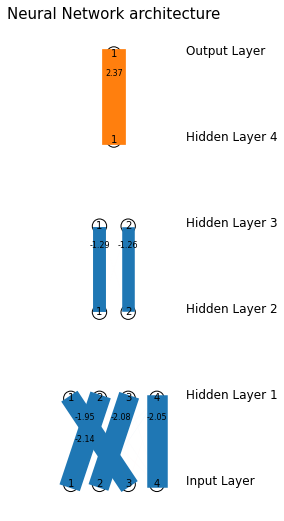

In [ ]:
visualize('weights/experiment1/ail_xnor', 'ail_xnor', 2)

#### relu

In [ ]:
model = MLP([4,4,2,1], 'relu', k=1)
train_model(model, [nested_train_dataset, nested_val_dataset], bs=64, output_dir='weights/')

========== Model Setup ==========
Activation Function: relu
p = 1, k = 1, g = 1
ModuleList(
  (0): Linear(in_features=4, out_features=4, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=4, out_features=2, bias=True)
  )
  (2): Linear(in_features=2, out_features=1, bias=True)
)
ModuleList(
  (0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Shuffle map 0: size 4
Shuffle map 1: size 2

Epoch: 0  |  LR = 0.00043  |   train_loss = 0.7107712030410767, train_acc = 0.5021033883094788  |  val_loss = 0.71599, val_acc = 0.47500  |  time = 0.73058
Epoch: 1  |  LR = 0.00050  |   train_loss = 0.7037392854690552, train_acc = 0.5018028616905212  |  val_loss = 0.70586, val_acc = 0.48400  |  time = 0.69995
Epoch: 2  |  LR = 0.00064  |   train_loss = 0.6987111568450928, train_acc = 0.5123196840286255  |  val_loss = 0.70088, val_acc = 0.50300  |  time = 0.70512
Epoch: 3  |  L

Layer 0
[[ 0.97006786  0.0968833   0.9765784  -0.25825   ]
 [ 0.05294268  1.1199983  -0.19444077  1.0346501 ]
 [-1.1108599  -0.03819248  0.2696523  -0.9914044 ]
 [ 0.07032001  1.0819434   1.1788206  -0.23379083]]

Layer 2
[[-0.85847116  0.6605532 ]
 [-0.8738256   0.7576295 ]
 [ 0.7165244  -0.90104085]
 [ 0.690617   -0.8637351 ]]

Layer 4
[[-0.8328075 ]
 [-0.75390923]]



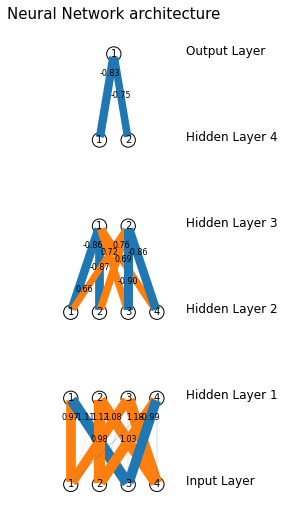

In [ ]:
visualize('weights/experiment1/relu', 'relu', 1)

In [ ]:
model = MLP([4,4,2,1], 'relu', k=1)
train_model(model, [nested_train_dataset, nested_val_dataset], bs=64)

========== Model Setup ==========
Activation Function: relu
p = 1, k = 1, g = 1
ModuleList(
  (0): Linear(in_features=4, out_features=4, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=4, out_features=2, bias=True)
  )
  (2): Linear(in_features=2, out_features=1, bias=True)
)
ModuleList(
  (0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Shuffle map 0: size 4
Shuffle map 1: size 2

Epoch:   1/ 100 | LR = 0.00043 | train_loss = 0.69962, train_acc = 50.581% | val_loss = 0.69585, val_acc = 50.900% | time = 0.696s
Epoch:   2/ 100 | LR = 0.00050 | train_loss = 0.69554, train_acc = 51.192% | val_loss = 0.69321, val_acc = 51.880% | time = 0.693s
Epoch:   3/ 100 | LR = 0.00064 | train_loss = 0.69277, train_acc = 52.093% | val_loss = 0.69095, val_acc = 53.720% | time = 0.700s
Epoch:   4/ 100 | LR = 0.00082 | train_loss = 0.69112, train_acc = 53.115% | val_loss = 0

In [ ]:
model = MLP([4,4,4,2,1], 'relu', k=1)
train_model(model, [nested_train_dataset, nested_val_dataset], bs=64)

========== Model Setup ==========
Activation Function: relu
p = 1, k = 1, g = 1
ModuleList(
  (0): Linear(in_features=4, out_features=4, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=4, out_features=2, bias=True)
  )
  (3): Linear(in_features=2, out_features=1, bias=True)
)
ModuleList(
  (0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Shuffle map 0: size 4
Shuffle map 1: size 4
Shuffle map 2: size 2

Epoch:   1/ 100 | LR = 0.00043 | train_loss = 0.71698, train_acc = 50.561% | val_loss = 0.71297, val_acc = 50.980% | time = 0.850s
Epoch:   2/ 100 | LR = 0.00050 | train_loss = 0.70736, train_acc = 50.591% | val_loss = 0.70594, val_acc = 50.980% | time = 0.799s
Epoch:   3/ 100 | LR = 0.00064 

In [ ]:
model = MLP([4,4,4,4,2,1], 'relu', k=1)
train_model(model, [nested_train_dataset, nested_val_dataset], bs=64)

========== Model Setup ==========
Activation Function: relu
p = 1, k = 1, g = 1
ModuleList(
  (0): Linear(in_features=4, out_features=4, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
  )
  (3): ModuleList(
    (0): Linear(in_features=4, out_features=2, bias=True)
  )
  (4): Linear(in_features=2, out_features=1, bias=True)
)
ModuleList(
  (0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Shuffle map 0: size 4
Shuffle map 1: size 4
Shuffle map 2: size 4
Shuffle map 3: size 2

Epoch:   1/ 100 | LR = 0.00043 | train_loss = 0.78949, train_acc = 49.409% | val_loss = 0.77570, val_acc

In [ ]:
model = MLP([4,4,4,4,4,4,1], 'relu', k=1)
train_model(model, [nested_train_dataset, nested_val_dataset], bs=64)

========== Model Setup ==========
Activation Function: relu
p = 1, k = 1, g = 1
ModuleList(
  (0): Linear(in_features=4, out_features=4, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
  )
  (3): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
  )
  (4): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
  )
  (5): Linear(in_features=4, out_features=1, bias=True)
)
ModuleList(
  (0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Shuffle map 0: size 4
Shuf

In [ ]:
model = MLP([4,4,4,4,4,4,4,4,1], 'relu', k=1)
train_model(model, [nested_train_dataset, nested_val_dataset], bs=64)

========== Model Setup ==========
Activation Function: relu
p = 1, k = 1, g = 1
ModuleList(
  (0): Linear(in_features=4, out_features=4, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
  )
  (3): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
  )
  (4): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
  )
  (5): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
  )
  (6): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
  )
  (7): Linear(in_features=4, out_features=1, bias=True)
)
ModuleList(
  (0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): BatchNorm1d(4, eps=1e-05, momen

In [ ]:
model = MLP([4,4,4,4,4,4,4,4,4,4,1], 'relu', k=1)
train_model(model, [nested_train_dataset, nested_val_dataset], bs=64)

========== Model Setup ==========
Activation Function: relu
p = 1, k = 1, g = 1
ModuleList(
  (0): Linear(in_features=4, out_features=4, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
  )
  (3): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
  )
  (4): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
  )
  (5): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
  )
  (6): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
  )
  (7): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
  )
  (8): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
  )
  (9): Linear(in_features=4, out_features=1, bias=True)
)
ModuleList(
  (0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, a

In [ ]:
model = MLP([4,6,4,4,4,2,1], 'relu', k=1)
train_model(model, [nested_train_dataset, nested_val_dataset], bs=64)

========== Model Setup ==========
Activation Function: relu
p = 1, k = 1, g = 1
ModuleList(
  (0): Linear(in_features=4, out_features=6, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=6, out_features=4, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
  )
  (3): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
  )
  (4): ModuleList(
    (0): Linear(in_features=4, out_features=2, bias=True)
  )
  (5): Linear(in_features=2, out_features=1, bias=True)
)
ModuleList(
  (0): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Shuffle map 0: size 6
Shuf

In [ ]:
model = MLP([4,8,8,1], 'relu', k=1)
train_model(model, [nested_train_dataset, nested_val_dataset], bs=64)

========== Model Setup ==========
Activation Function: relu
p = 1, k = 1, g = 1
ModuleList(
  (0): Linear(in_features=4, out_features=8, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=8, out_features=8, bias=True)
  )
  (2): Linear(in_features=8, out_features=1, bias=True)
)
ModuleList(
  (0): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Shuffle map 0: size 8
Shuffle map 1: size 8

Epoch:   1/ 100 | LR = 0.00043 | train_loss = 0.70521, train_acc = 50.030% | val_loss = 0.69710, val_acc = 51.080% | time = 0.712s
Epoch:   2/ 100 | LR = 0.00050 | train_loss = 0.69418, train_acc = 51.302% | val_loss = 0.68992, val_acc = 52.720% | time = 0.653s
Epoch:   3/ 100 | LR = 0.00064 | train_loss = 0.68790, train_acc = 54.297% | val_loss = 0.68417, val_acc = 56.240% | time = 0.662s
Epoch:   4/ 100 | LR = 0.00082 | train_loss = 0.68198, train_acc = 57.772% | val_loss = 0

In [ ]:
model = MLP([4,8,8,8,1], 'relu', k=1)
train_model(model, [nested_train_dataset, nested_val_dataset], bs=64)

========== Model Setup ==========
Activation Function: relu
p = 1, k = 1, g = 1
ModuleList(
  (0): Linear(in_features=4, out_features=8, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=8, out_features=8, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=8, out_features=8, bias=True)
  )
  (3): Linear(in_features=8, out_features=1, bias=True)
)
ModuleList(
  (0): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Shuffle map 0: size 8
Shuffle map 1: size 8
Shuffle map 2: size 8

Epoch:   1/ 100 | LR = 0.00043 | train_loss = 0.69601, train_acc = 53.876% | val_loss = 0.68787, val_acc = 54.380% | time = 0.817s
Epoch:   2/ 100 | LR = 0.00050 | train_loss = 0.68276, train_acc = 55.859% | val_loss = 0.67760, val_acc = 57.040% | time = 0.824s
Epoch:   3/ 100 | LR = 0.00064 

In [ ]:
model = MLP([4,8,8,4,4,2,1], 'relu', k=1)
train_model(model, [nested_train_dataset, nested_val_dataset], bs=64)

========== Model Setup ==========
Activation Function: relu
p = 1, k = 1, g = 1
ModuleList(
  (0): Linear(in_features=4, out_features=8, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=8, out_features=8, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=8, out_features=4, bias=True)
  )
  (3): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
  )
  (4): ModuleList(
    (0): Linear(in_features=4, out_features=2, bias=True)
  )
  (5): Linear(in_features=2, out_features=1, bias=True)
)
ModuleList(
  (0): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Shuffle map 0: size 8
Shuf

#### Print truth table

In [ ]:
import itertools

def np_xnor(a, b):
    return np.logical_not(np.logical_xor(a, b))

In [ ]:
print("y  = XNOR(XNOR(x1,x2),XNOR(x3,x4))")
print("y' = XNOR( XOR(x3, x1), XOR(x2, x4) )")

fs = "{:>2} {:>2} {:>2} {:>2} {:>2} {:>2}"
print(fs.format("x1", "x2", "x3", "x4", "y", "y'"))

for x1, x2, x3, x4 in itertools.product((0, 1), repeat=4):
    print(
        fs.format(
            x1, x2, x3, x4,
            np_xnor(np_xnor(x1, x2), np_xnor(x3, x4)),
            np_xnor(np.logical_xor(x3, x1), np.logical_xor(x2, x4)),
        )
    )

y  = XNOR(XNOR(x1,x2),XNOR(x3,x4))
y' = XNOR( XOR(x3, x1), XOR(x2, x4) )
x1 x2 x3 x4  y y'
 0  0  0  0  1  1
 0  0  0  1  0  0
 0  0  1  0  0  0
 0  0  1  1  1  1
 0  1  0  0  0  0
 0  1  0  1  1  1
 0  1  1  0  1  1
 0  1  1  1  0  0
 1  0  0  0  0  0
 1  0  0  1  1  1
 1  0  1  0  1  1
 1  0  1  1  0  0
 1  1  0  0  1  1
 1  1  0  1  0  0
 1  1  1  0  0  0
 1  1  1  1  1  1


In [ ]:
print("y  = XNOR(XNOR(x1,x2),XNOR(x3,x4))")

fs = "{:>2} {:>2} {:>2} {:>2} {:>16} {:>16} {:>16}"
print(fs.format("x1", "x2", "x3", "x4", "XNOR(x1,x2)", "XNOR(x3,x4)", "XNOR(XNOR(x1,x2),XNOR(x3,x4))"))

for x1, x2, x3, x4 in itertools.product((0, 1), repeat=4):
    print(
        fs.format(
            x1, x2, x3, x4,
            np_xnor(x1, x2),
            np_xnor(x3, x4),
            np_xnor(np_xnor(x1, x2), np_xnor(x3, x4)),
        )
    )

y  = XNOR(XNOR(x1,x2),XNOR(x3,x4))
x1 x2 x3 x4      XNOR(x1,x2)      XNOR(x3,x4) XNOR(XNOR(x1,x2),XNOR(x3,x4))
 0  0  0  0                1                1                1
 0  0  0  1                1                0                0
 0  0  1  0                1                0                0
 0  0  1  1                1                1                1
 0  1  0  0                0                1                0
 0  1  0  1                0                0                1
 0  1  1  0                0                0                1
 0  1  1  1                0                1                0
 1  0  0  0                0                1                0
 1  0  0  1                0                0                1
 1  0  1  0                0                0                1
 1  0  1  1                0                1                0
 1  1  0  0                1                1                1
 1  1  0  1                1                0                0
 1  1  

In [ ]:
print("y' = XNOR( XOR(x3, x1), XOR(x2, x4) )")

fs = "{:>2} {:>2} {:>2} {:>2} {:>16} {:>16} {:>16}"
print(fs.format("x1", "x2", "x3", "x4", "XOR(x3, x1)", "XOR(x2, x4)", "XNOR( XOR(x3, x1), XOR(x2, x4) )"))

for x1, x2, x3, x4 in itertools.product((0, 1), repeat=4):
    print(
        fs.format(
            x1, x2, x3, x4,
            np.logical_xor(x3, x1),
            np.logical_xor(x2, x4),
            np_xnor(np.logical_xor(x3, x1), np.logical_xor(x2, x4)),
        )
    )

y' = XNOR( XOR(x3, x1), XOR(x2, x4) )
x1 x2 x3 x4      XOR(x3, x1)      XOR(x2, x4) XNOR( XOR(x3, x1), XOR(x2, x4) )
 0  0  0  0                0                0                1
 0  0  0  1                0                1                0
 0  0  1  0                1                0                0
 0  0  1  1                1                1                1
 0  1  0  0                0                1                0
 0  1  0  1                0                0                1
 0  1  1  0                1                1                1
 0  1  1  1                1                0                0
 1  0  0  0                1                0                0
 1  0  0  1                1                1                1
 1  0  1  0                0                0                1
 1  0  1  1                0                1                0
 1  1  0  0                1                1                1
 1  1  0  1                1                0                0
 

## Custom Mappings

In [ ]:
label_function = Xnor_Custom(nested_operations=3)

Labelling function: XNOR( XNOR( XNOR( 6, 4 ), XNOR( 1, 3 ) ), XNOR( XNOR( 0, 2 ), XNOR( 7, 5 ) ) )



#### ail_xnor

In [ ]:
print("Label Function:")
print(label_function)
print()

nested_train_dataset = MappingDataset(label_function, num_samples=10000)
nested_val_dataset = MappingDataset(label_function, num_samples=5000)
model = MLP([8,8,4,2,1], 'ail_xnor')
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=100, bs=64, max_lr=0.01, output_dir='weights/experiment2/', verbose=True)

Label Function:
XNOR( XNOR( XNOR( 6, 4 ), XNOR( 1, 3 ) ), XNOR( XNOR( 0, 2 ), XNOR( 7, 5 ) ) )

========== Model Setup ==========
Activation Function: ail_xnor
p = 1, k = 2, g = 1
ModuleList(
  (0): Linear(in_features=8, out_features=8, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=True)
  )
  (3): Linear(in_features=1, out_features=1, bias=True)
)
ModuleList(
  (0): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Shuffle map 0: size 8
Shuffle map 1: size 4
Shuffle map 2: size 2

--------------
Start training
--------------
Epoch:   1/ 100 | LR = 0.00043 | train_loss = 0.70358, train_acc = 50.130% | val_loss = 0.70056, val_acc = 50.340% | time = 1.917s
  Sample from val

#### relu

In [ ]:
print("Label Function:")
print(label_function)
print()

model = MLP([label_function.get_num_inputs(),8,4,2,1], 'relu', k=1)
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=100, bs=64, max_lr=0.01, output_dir='weights/experiment2/', verbose=True)

Label Function:
XNOR( XNOR( XNOR( 4, 7 ), XNOR( 5, 6 ) ), XNOR( XNOR( 1, 3 ), XNOR( 2, 0 ) ) )

========== Model Setup ==========
Activation Function: relu
p = 1, k = 1, g = 1
ModuleList(
  (0): Linear(in_features=8, out_features=8, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=8, out_features=4, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=4, out_features=2, bias=True)
  )
  (3): Linear(in_features=2, out_features=1, bias=True)
)
ModuleList(
  (0): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Shuffle map 0: size 8
Shuffle map 1: size 4
Shuffle map 2: size 2

--------------
Start training
--------------
Epoch:   1/ 100 | LR = 0.00043 | train_loss = 0.72132, train_acc = 49.219% | val_loss = 0.71348, val_acc = 50.740% | time = 2.445s
  Sample from validat

## Sanity Check

#### Redoing 2 nested operation experiment w/ custom labelling function
```
With new code, network is still able to solve problems with two nested operations.
```



In [ ]:
label_function = Xnor_Custom(nested_operations=2)

Labelling function: XNOR( XNOR( 1, 3 ), XNOR( 0, 2 ) )



In [ ]:
print("Label Function:")
print(label_function)
print()

nested_train_dataset = MappingDataset(label_function, num_samples=10000)
nested_val_dataset = MappingDataset(label_function, num_samples=5000)
model = MLP([4,4,2,1], 'ail_xnor')
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=20, bs=64, max_lr=0.01, output_dir='weights/sanity_check/', verbose=True)

Label Function:
XNOR( XNOR( 1, 3 ), XNOR( 0, 2 ) )

========== Model Setup ==========
Activation Function: ail_xnor
p = 1, k = 2, g = 1
ModuleList(
  (0): Linear(in_features=4, out_features=4, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=True)
  )
  (2): Linear(in_features=1, out_features=1, bias=True)
)
ModuleList(
  (0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Shuffle map 0: size 4
Shuffle map 1: size 2

--------------
Start training
--------------
Epoch:   1/  20 | LR = 0.00104 | train_loss = 0.69252, train_acc = 52.905% | val_loss = 0.68308, val_acc = 58.100% | time = 0.741s
  Sample from validation set:
    Input: [0.842  0.4559 0.1606 0.4406]
    Output: [0.09842309]
    Target: [0.]

Epoch:   2/  20 | LR = 0.00280 | train_loss = 0.67560, train_acc = 59.445% | val_loss = 0.66230, val_acc = 62.880% | time = 0.719s
  Sam

Layer 0
[[ 4.9849381e-03  8.7091886e-03 -1.4630635e-02  1.2243534e+00]
 [-7.9468023e-03 -1.3094477e-03  1.5955310e+00 -6.6251676e-03]
 [-1.2133485e+00  7.5725899e-03 -5.4360209e-03  3.6313105e-03]
 [-7.5688809e-03  1.5802817e+00  1.0512874e-02 -5.7701385e-03]]

Layer 2
[[ 1.513349    0.00925041]
 [-0.01693512 -1.1041187 ]]

Layer 4
[[2.1764839]]



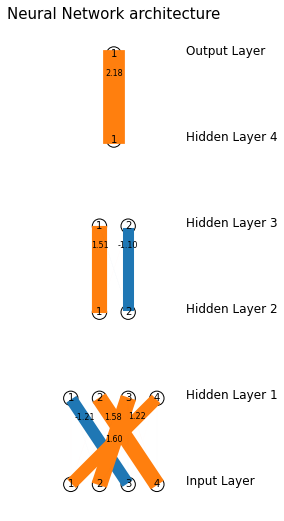

In [ ]:
visualize([4,4,2,1], 'weights/sanity_check/ail_xnor', 'ail_xnor', 2)

In [ ]:
print("\nModel learns correct mapping: {}".format(label_function.compare_truth_tables(model, print_tables=True)))

[0, 0, 0, 0]  |  Model: 1, Label: 1
[0, 0, 0, 1]  |  Model: 0, Label: 0
[0, 0, 1, 0]  |  Model: 0, Label: 0
[0, 0, 1, 1]  |  Model: 1, Label: 1
[0, 1, 0, 0]  |  Model: 0, Label: 0
[0, 1, 0, 1]  |  Model: 1, Label: 1
[0, 1, 1, 0]  |  Model: 1, Label: 1
[0, 1, 1, 1]  |  Model: 0, Label: 0
[1, 0, 0, 0]  |  Model: 0, Label: 0
[1, 0, 0, 1]  |  Model: 1, Label: 1
[1, 0, 1, 0]  |  Model: 1, Label: 1
[1, 0, 1, 1]  |  Model: 0, Label: 0
[1, 1, 0, 0]  |  Model: 1, Label: 1
[1, 1, 0, 1]  |  Model: 0, Label: 0
[1, 1, 1, 0]  |  Model: 0, Label: 0
[1, 1, 1, 1]  |  Model: 1, Label: 1

Model learns correct mapping: True


#### Testing 3 nested operations with pre-defined weight matrix

```
The model is not able to identify a sparse weight matrix by training. 
We show that by defining the weight matrix by hand, we can get >95% accuracy.
Large weight magnitudes necessary to achieve this high accuracy.
```



###### Attempting to solve by training

In [ ]:
seed = 42

label_function = Xnor_Custom(nested_operations=3, seed=seed, input_as_logit=True)

nested_train_dataset = MappingDataset(label_function, num_samples=10000, 
                                      seed=seed, input_as_logit=True)
nested_val_dataset = MappingDataset(label_function, num_samples=5000, 
                                    seed=seed, input_as_logit=True)

Labelling function: XNOR( XNOR( XNOR( 2, 5 ), XNOR( 3, 4 ) ), XNOR( XNOR( 6, 7 ), XNOR( 0, 1 ) ) )



In [ ]:
print("Label Function:")
print(label_function)
print()

model = MLP([8,8,4,2,1], 'ail_xnor', bn=False)
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=100, 
            bs=64, max_lr=0.01, output_dir='weights/sanity_check_logits/', 
            verbose=True, label="new")

Label Function:
XNOR( XNOR( XNOR( 2, 5 ), XNOR( 3, 4 ) ), XNOR( XNOR( 6, 7 ), XNOR( 0, 1 ) ) )

========== Model Setup ==========
Activation Function: ail_xnor
p = 1, k = 2, g = 1
ModuleList(
  (0): Linear(in_features=8, out_features=8, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=True)
  )
  (3): Linear(in_features=1, out_features=1, bias=True)
)
Batch norm OFF
Shuffle map 0: size 8
Shuffle map 1: size 4
Shuffle map 2: size 2

--------------
Start training
--------------
Epoch:   1/ 100 | LR = 0.00043 | train_loss = 0.73860, train_acc = 49.099% | val_loss = 0.73475, val_acc = 48.400% | time = 0.620s
  Sample from validation set:
    Input: [ 1.1387 -0.9323 -0.2059  3.516   1.7679 -2.7237 -0.9659  1.3555]
    Output: [-0.573367]
    Target: [1.]

Epoch:   2/ 100 | LR = 0.00050 | train_loss = 0.72372, train_acc = 49.089% | val_loss = 0.72128, val_acc = 48.400% | time = 0

================ Layer 0
[[-0.20140646  0.22805408 -0.20154636  0.5876929   0.5785799  -0.03476942
   0.89565974 -0.91076636]
 [ 0.33314377  1.206903    0.95958316  0.7612522  -0.07308925 -0.4666137
   0.4627632  -0.4699508 ]
 [-0.7874835  -1.1625856   0.7356989   0.37421942  0.16009635  0.04601897
   0.23877661 -0.35666716]
 [ 0.12241448  0.28854048 -1.5632626   0.22266965  0.54913986  0.5144836
   0.30775607 -0.1159365 ]
 [ 0.75428665 -0.19580616 -0.5973304   0.02808771  0.33573562  0.02958692
  -0.5885544  -1.1570687 ]
 [-0.3456225  -0.4583161   0.01928711 -0.7221472   1.1237583   0.08419886
   0.5578389  -0.1607153 ]
 [ 0.6798628   0.6505393  -0.11624697  0.5055038   1.0852847   0.13504647
   0.31319395  0.6853753 ]
 [ 0.5497298   0.48807287 -0.0679311   0.18735132 -0.02066546 -0.01311923
  -0.49894345  0.28192434]]

================ Layer 2
[[ 0.08602805  1.6179843   0.16426978  0.76684374]
 [ 0.30806154 -0.08117957  0.9797298  -0.34411564]
 [-0.68869996 -0.20872962 -0.24928442  0

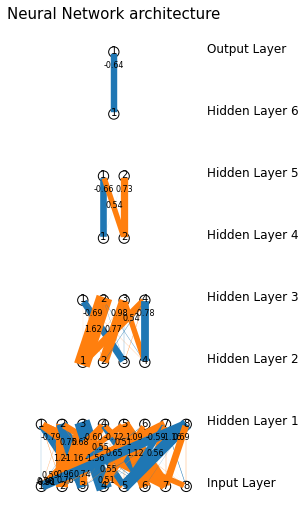

In [ ]:
visualize([8,8,4,2,1], 'weights/sanity_check_logits/ail_xnor_new', 'ail_xnor', 2, bn=False)

###### Defining weights by hand

In [ ]:
print(label_function)

XNOR( XNOR( XNOR( 2, 5 ), XNOR( 3, 4 ) ), XNOR( XNOR( 6, 7 ), XNOR( 0, 1 ) ) )


val_loss = 0.58996, val_acc =100.000%

================ Layer 0
[[0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]]

================ Layer 2
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

================ Layer 4
[[1. 0.]
 [0. 1.]]

================ Layer 6
[[1.]]



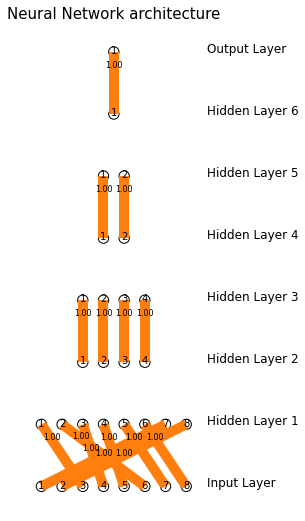

In [ ]:
new_weight_dict = change_state_dict(model, 1.)
evaluate_model(new_weight_dict, nested_val_dataset, bn=False)
print()
visualize([8,8,4,2,1], None, 'ail_xnor', 2, state_dict=new_weight_dict, bn=False)

#### Increasing model width until able to solve
```
ail_xnor: needs to increase to 32x to get >95% accuracy
relu: needs to increase to 128x to get >95% accuracy
```

###### ail_xnor

In [ ]:
model = MLP([8,16,8,4,1], 'ail_xnor', bn=False)
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=100, 
            bs=64, max_lr=0.01, output_dir='weights/sanity_check_logits_larger_capacity/', 
            label="2x", print_every=10)

========== Model Setup ==========
Activation Function: ail_xnor
p = 1, k = 2, g = 1
ModuleList(
  (0): Linear(in_features=8, out_features=16, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=8, out_features=8, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
  )
  (3): Linear(in_features=2, out_features=1, bias=True)
)
Batch norm OFF
Shuffle map 0: size 16
Shuffle map 1: size 8
Shuffle map 2: size 4

--------------
Start training
--------------
Epoch:  10/ 100 | LR = 0.00280 | train_loss = 0.68967, train_acc = 53.606% | val_loss = 0.68676, val_acc = 55.500% | time = 0.561s
Epoch:  20/ 100 | LR = 0.00760 | train_loss = 0.68781, train_acc = 54.157% | val_loss = 0.68349, val_acc = 55.800% | time = 0.566s
Epoch:  30/ 100 | LR = 0.01000 | train_loss = 0.68495, train_acc = 55.359% | val_loss = 0.67902, val_acc = 56.160% | time = 0.552s
Epoch:  40/ 100 | LR = 0.00950 | train_loss = 0.68244, train_acc = 56.270% | val_loss = 0.68131, val_acc =

In [ ]:
model = MLP([8,32,16,8,1], 'ail_xnor', bn=False)
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=100, 
            bs=64, max_lr=0.01, output_dir='weights/sanity_check_logits_larger_capacity/', 
            label="4x", print_every=10)

========== Model Setup ==========
Activation Function: ail_xnor
p = 1, k = 2, g = 1
ModuleList(
  (0): Linear(in_features=8, out_features=32, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=16, out_features=16, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=8, out_features=8, bias=True)
  )
  (3): Linear(in_features=4, out_features=1, bias=True)
)
Batch norm OFF
Shuffle map 0: size 32
Shuffle map 1: size 16
Shuffle map 2: size 8

--------------
Start training
--------------
Epoch:  10/ 100 | LR = 0.00280 | train_loss = 0.68498, train_acc = 55.128% | val_loss = 0.68058, val_acc = 56.920% | time = 0.571s
Epoch:  20/ 100 | LR = 0.00760 | train_loss = 0.67676, train_acc = 57.141% | val_loss = 0.67260, val_acc = 58.180% | time = 0.566s
Epoch:  30/ 100 | LR = 0.01000 | train_loss = 0.67132, train_acc = 58.574% | val_loss = 0.65371, val_acc = 60.980% | time = 0.574s
Epoch:  40/ 100 | LR = 0.00950 | train_loss = 0.65983, train_acc = 60.246% | val_loss = 0.64401, val_ac

In [ ]:
model = MLP([8,64,32,16,1], 'ail_xnor', bn=False)
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=100, 
            bs=64, max_lr=0.01, output_dir='weights/sanity_check_logits_larger_capacity/', 
            label="8x", print_every=10)

========== Model Setup ==========
Activation Function: ail_xnor
p = 1, k = 2, g = 1
ModuleList(
  (0): Linear(in_features=8, out_features=64, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=32, out_features=32, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=16, out_features=16, bias=True)
  )
  (3): Linear(in_features=8, out_features=1, bias=True)
)
Batch norm OFF
Shuffle map 0: size 64
Shuffle map 1: size 32
Shuffle map 2: size 16

--------------
Start training
--------------
Epoch:  10/ 100 | LR = 0.00280 | train_loss = 0.66867, train_acc = 58.754% | val_loss = 0.65001, val_acc = 62.280% | time = 0.590s
Epoch:  20/ 100 | LR = 0.00760 | train_loss = 0.65220, train_acc = 61.418% | val_loss = 0.62636, val_acc = 65.520% | time = 0.558s
Epoch:  30/ 100 | LR = 0.01000 | train_loss = 0.64507, train_acc = 61.879% | val_loss = 0.60510, val_acc = 68.100% | time = 0.564s
Epoch:  40/ 100 | LR = 0.00950 | train_loss = 0.62054, train_acc = 65.204% | val_loss = 0.59347, val

In [ ]:
model = MLP([8,128,64,32,1], 'ail_xnor', bn=False)
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=100, 
            bs=64, max_lr=0.01, output_dir='weights/sanity_check_logits_larger_capacity/', 
            label="16x", print_every=10)

========== Model Setup ==========
Activation Function: ail_xnor
p = 1, k = 2, g = 1
ModuleList(
  (0): Linear(in_features=8, out_features=128, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=32, out_features=32, bias=True)
  )
  (3): Linear(in_features=16, out_features=1, bias=True)
)
Batch norm OFF
Shuffle map 0: size 128
Shuffle map 1: size 64
Shuffle map 2: size 32

--------------
Start training
--------------
Epoch:  10/ 100 | LR = 0.00280 | train_loss = 0.63196, train_acc = 64.223% | val_loss = 0.59565, val_acc = 67.820% | time = 0.582s
Epoch:  20/ 100 | LR = 0.00760 | train_loss = 0.60463, train_acc = 66.707% | val_loss = 0.54337, val_acc = 73.620% | time = 0.581s
Epoch:  30/ 100 | LR = 0.01000 | train_loss = 0.58562, train_acc = 68.409% | val_loss = 0.52239, val_acc = 75.000% | time = 0.600s
Epoch:  40/ 100 | LR = 0.00950 | train_loss = 0.53375, train_acc = 73.097% | val_loss = 0.48431, 

In [ ]:
model = MLP([8,128,64,32,1], 'ail_xnor', bn=False)
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=100, 
            bs=64, max_lr=0.001, output_dir='weights/sanity_check_logits_larger_capacity/', 
            label="16x_001", print_every=10)

========== Model Setup ==========
Activation Function: ail_xnor
p = 1, k = 2, g = 1
ModuleList(
  (0): Linear(in_features=8, out_features=128, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=32, out_features=32, bias=True)
  )
  (3): Linear(in_features=16, out_features=1, bias=True)
)
Batch norm OFF
Shuffle map 0: size 128
Shuffle map 1: size 64
Shuffle map 2: size 32

--------------
Start training
--------------
Epoch:  10/ 100 | LR = 0.00028 | train_loss = 0.68409, train_acc = 58.143% | val_loss = 0.68152, val_acc = 58.800% | time = 0.581s
Epoch:  20/ 100 | LR = 0.00076 | train_loss = 0.59842, train_acc = 68.159% | val_loss = 0.56531, val_acc = 72.120% | time = 0.582s
Epoch:  30/ 100 | LR = 0.00100 | train_loss = 0.47476, train_acc = 77.344% | val_loss = 0.42321, val_acc = 82.580% | time = 0.575s
Epoch:  40/ 100 | LR = 0.00095 | train_loss = 0.36705, train_acc = 83.904% | val_loss = 0.31482, 

================ Layer 0
[[-1.0930457   0.3721842  -0.46506977 ... -0.6304511   0.11324696
   0.89420563]
 [ 0.5694491  -0.05664517 -0.5160787  ...  0.05676611 -0.8378321
  -0.64844453]
 [ 1.1585224   0.8551757   0.06306911 ... -0.9612721  -0.6981317
   1.1813278 ]
 ...
 [-0.68722016 -0.08756984 -0.47327304 ... -0.07837741  0.41998312
  -0.4076175 ]
 [-0.3722848   0.22944154  0.6978528  ...  0.93224686 -0.49435154
  -0.32187882]
 [ 1.0287347   0.3433725  -0.2948303  ...  0.30398893 -0.81783015
   0.17034774]]

================ Layer 2
[[-0.10637445 -1.0143651   0.7112737  ...  0.5743203  -0.16625151
   0.75368464]
 [ 0.29794505 -0.68804914 -0.8641084  ... -0.9997065   0.6643812
   0.815076  ]
 [ 0.0328386  -0.6960114   0.2363256  ...  0.521208   -0.02893349
  -0.33950794]
 ...
 [ 0.33922613  0.06771002  0.12021024 ...  0.04112002 -0.13789698
  -0.21818595]
 [-0.26613247 -0.30338612  0.1356528  ...  0.23617403  0.3398428
   0.4309412 ]
 [ 0.12792848  1.3556886  -0.31893617 ...  0.276434

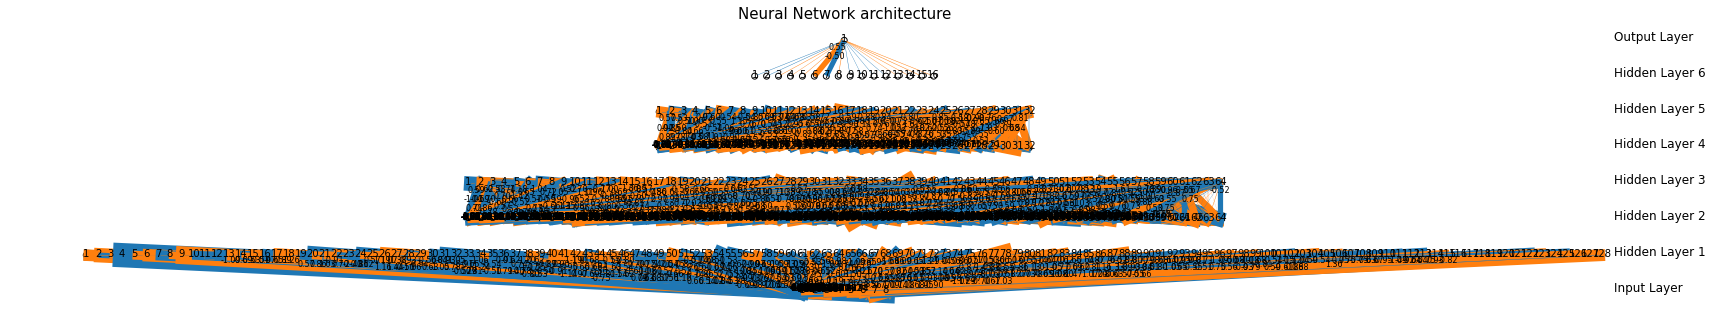

In [ ]:
visualize([8,128,64,32,1], 'weights/sanity_check_logits_larger_capacity/ail_xnor_16x', 'ail_xnor', 2, new_figsize=(30,40), bn=False)

###### relu

In [ ]:
model = MLP([8,16,8,4,1], 'relu', k=1, bn=False)
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=100, 
            bs=64, max_lr=0.01, output_dir='weights/sanity_check_logits_larger_capacity/', 
            label="2x", print_every=10)

========== Model Setup ==========
Activation Function: relu
p = 1, k = 1, g = 1
ModuleList(
  (0): Linear(in_features=8, out_features=16, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=16, out_features=8, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=8, out_features=4, bias=True)
  )
  (3): Linear(in_features=4, out_features=1, bias=True)
)
Batch norm OFF
Shuffle map 0: size 16
Shuffle map 1: size 8
Shuffle map 2: size 4

--------------
Start training
--------------
Epoch:  10/ 100 | LR = 0.00280 | train_loss = 0.69170, train_acc = 52.153% | val_loss = 0.69075, val_acc = 53.200% | time = 0.446s
Epoch:  20/ 100 | LR = 0.00760 | train_loss = 0.69105, train_acc = 52.314% | val_loss = 0.68943, val_acc = 54.480% | time = 0.446s
Epoch:  30/ 100 | LR = 0.01000 | train_loss = 0.68998, train_acc = 52.364% | val_loss = 0.68763, val_acc = 54.440% | time = 0.447s
Epoch:  40/ 100 | LR = 0.00950 | train_loss = 0.68790, train_acc = 52.344% | val_loss = 0.68552, val_acc = 54

In [ ]:
model = MLP([8,32,16,8,1], 'relu', k=1, bn=False)
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=100, 
            bs=64, max_lr=0.01, output_dir='weights/sanity_check_logits_larger_capacity/', 
            label="4x", print_every=10)

========== Model Setup ==========
Activation Function: relu
p = 1, k = 1, g = 1
ModuleList(
  (0): Linear(in_features=8, out_features=32, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=32, out_features=16, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=16, out_features=8, bias=True)
  )
  (3): Linear(in_features=8, out_features=1, bias=True)
)
Batch norm OFF
Shuffle map 0: size 32
Shuffle map 1: size 16
Shuffle map 2: size 8

--------------
Start training
--------------
Epoch:  10/ 100 | LR = 0.00280 | train_loss = 0.69090, train_acc = 53.075% | val_loss = 0.69028, val_acc = 52.900% | time = 0.442s
Epoch:  20/ 100 | LR = 0.00760 | train_loss = 0.69056, train_acc = 53.205% | val_loss = 0.68909, val_acc = 52.920% | time = 0.446s
Epoch:  30/ 100 | LR = 0.01000 | train_loss = 0.69036, train_acc = 52.604% | val_loss = 0.68804, val_acc = 54.700% | time = 0.440s
Epoch:  40/ 100 | LR = 0.00950 | train_loss = 0.68726, train_acc = 53.896% | val_loss = 0.68300, val_acc =

In [ ]:
model = MLP([8,64,32,16,1], 'relu', k=1, bn=False)
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=100, 
            bs=64, max_lr=0.01, output_dir='weights/sanity_check_logits_larger_capacity/', 
            label="8x", print_every=10)

========== Model Setup ==========
Activation Function: relu
p = 1, k = 1, g = 1
ModuleList(
  (0): Linear(in_features=8, out_features=64, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=64, out_features=32, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=32, out_features=16, bias=True)
  )
  (3): Linear(in_features=16, out_features=1, bias=True)
)
Batch norm OFF
Shuffle map 0: size 64
Shuffle map 1: size 32
Shuffle map 2: size 16

--------------
Start training
--------------
Epoch:  10/ 100 | LR = 0.00280 | train_loss = 0.69109, train_acc = 52.784% | val_loss = 0.68913, val_acc = 54.660% | time = 0.445s
Epoch:  20/ 100 | LR = 0.00760 | train_loss = 0.69069, train_acc = 52.935% | val_loss = 0.69111, val_acc = 52.280% | time = 0.447s
Epoch:  30/ 100 | LR = 0.01000 | train_loss = 0.69019, train_acc = 52.564% | val_loss = 0.68983, val_acc = 52.840% | time = 0.440s
Epoch:  40/ 100 | LR = 0.00950 | train_loss = 0.69063, train_acc = 52.885% | val_loss = 0.68905, val_ac

In [ ]:
model = MLP([8,128,64,32,1], 'relu', k=1, bn=False)
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=100, 
            bs=64, max_lr=0.01, output_dir='weights/sanity_check_logits_larger_capacity/', 
            label="16x", print_every=10)

========== Model Setup ==========
Activation Function: relu
p = 1, k = 1, g = 1
ModuleList(
  (0): Linear(in_features=8, out_features=128, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=128, out_features=64, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=64, out_features=32, bias=True)
  )
  (3): Linear(in_features=32, out_features=1, bias=True)
)
Batch norm OFF
Shuffle map 0: size 128
Shuffle map 1: size 64
Shuffle map 2: size 32

--------------
Start training
--------------
Epoch:  10/ 100 | LR = 0.00280 | train_loss = 0.69061, train_acc = 52.564% | val_loss = 0.69110, val_acc = 54.260% | time = 0.445s
Epoch:  20/ 100 | LR = 0.00760 | train_loss = 0.69187, train_acc = 51.723% | val_loss = 0.69107, val_acc = 53.100% | time = 0.445s
Epoch:  30/ 100 | LR = 0.01000 | train_loss = 0.69318, train_acc = 50.621% | val_loss = 0.69274, val_acc = 51.600% | time = 0.464s
Epoch:  40/ 100 | LR = 0.00950 | train_loss = 0.69273, train_acc = 51.472% | val_loss = 0.69330, val

In [ ]:
model = MLP([8,256,128,64,1], 'relu', k=1, bn=False)
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=100, 
            bs=64, max_lr=0.01, output_dir='weights/sanity_check_logits_larger_capacity/', 
            label="32x", print_every=10)

========== Model Setup ==========
Activation Function: relu
p = 1, k = 1, g = 1
ModuleList(
  (0): Linear(in_features=8, out_features=256, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=128, out_features=64, bias=True)
  )
  (3): Linear(in_features=64, out_features=1, bias=True)
)
Batch norm OFF
Shuffle map 0: size 256
Shuffle map 1: size 128
Shuffle map 2: size 64

--------------
Start training
--------------
Epoch:  10/ 100 | LR = 0.00280 | train_loss = 0.69152, train_acc = 52.955% | val_loss = 0.68900, val_acc = 53.780% | time = 0.456s
Epoch:  20/ 100 | LR = 0.00760 | train_loss = 0.69314, train_acc = 50.861% | val_loss = 0.69249, val_acc = 51.680% | time = 0.450s
Epoch:  30/ 100 | LR = 0.01000 | train_loss = 0.69327, train_acc = 50.661% | val_loss = 0.69263, val_acc = 51.880% | time = 0.451s
Epoch:  40/ 100 | LR = 0.00950 | train_loss = 0.69312, train_acc = 51.162% | val_loss = 0.69274, 

In [ ]:
model = MLP([8,128,64,32,1], 'relu', k=1, bn=False)
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=100, 
            bs=64, max_lr=0.001, output_dir='weights/sanity_check_logits_larger_capacity/', 
            label="16x_001", print_every=10)

========== Model Setup ==========
Activation Function: relu
p = 1, k = 1, g = 1
ModuleList(
  (0): Linear(in_features=8, out_features=128, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=128, out_features=64, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=64, out_features=32, bias=True)
  )
  (3): Linear(in_features=32, out_features=1, bias=True)
)
Batch norm OFF
Shuffle map 0: size 128
Shuffle map 1: size 64
Shuffle map 2: size 32

--------------
Start training
--------------
Epoch:  10/ 100 | LR = 0.00028 | train_loss = 0.69116, train_acc = 52.815% | val_loss = 0.68963, val_acc = 53.940% | time = 0.452s
Epoch:  20/ 100 | LR = 0.00076 | train_loss = 0.68508, train_acc = 55.168% | val_loss = 0.68007, val_acc = 56.840% | time = 0.443s
Epoch:  30/ 100 | LR = 0.00100 | train_loss = 0.66472, train_acc = 59.054% | val_loss = 0.65629, val_acc = 60.620% | time = 0.451s
Epoch:  40/ 100 | LR = 0.00095 | train_loss = 0.62438, train_acc = 64.744% | val_loss = 0.60997, val

In [ ]:
model = MLP([8,256,128,64,1], 'relu', k=1, bn=False)
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=100, 
            bs=64, max_lr=0.001, output_dir='weights/sanity_check_logits_larger_capacity/', 
            label="32x_001", print_every=10)

========== Model Setup ==========
Activation Function: relu
p = 1, k = 1, g = 1
ModuleList(
  (0): Linear(in_features=8, out_features=256, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=128, out_features=64, bias=True)
  )
  (3): Linear(in_features=64, out_features=1, bias=True)
)
Batch norm OFF
Shuffle map 0: size 256
Shuffle map 1: size 128
Shuffle map 2: size 64

--------------
Start training
--------------
Epoch:  10/ 100 | LR = 0.00028 | train_loss = 0.68938, train_acc = 53.746% | val_loss = 0.68786, val_acc = 54.400% | time = 0.460s
Epoch:  20/ 100 | LR = 0.00076 | train_loss = 0.67989, train_acc = 56.420% | val_loss = 0.67614, val_acc = 57.260% | time = 0.451s
Epoch:  30/ 100 | LR = 0.00100 | train_loss = 0.65545, train_acc = 60.637% | val_loss = 0.63714, val_acc = 63.320% | time = 0.448s
Epoch:  40/ 100 | LR = 0.00095 | train_loss = 0.59717, train_acc = 66.546% | val_loss = 0.58033, 

In [ ]:
model = MLP([8,256,128,64,1], 'relu', k=1, bn=False)
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=100, 
            bs=64, max_lr=0.0001, output_dir='weights/sanity_check_logits_larger_capacity/', 
            label="32x_0001", print_every=10)

========== Model Setup ==========
Activation Function: relu
p = 1, k = 1, g = 1
ModuleList(
  (0): Linear(in_features=8, out_features=256, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=128, out_features=64, bias=True)
  )
  (3): Linear(in_features=64, out_features=1, bias=True)
)
Batch norm OFF
Shuffle map 0: size 256
Shuffle map 1: size 128
Shuffle map 2: size 64

--------------
Start training
--------------
Epoch:  10/ 100 | LR = 0.00003 | train_loss = 0.69177, train_acc = 52.284% | val_loss = 0.69106, val_acc = 52.820% | time = 0.445s
Epoch:  20/ 100 | LR = 0.00008 | train_loss = 0.68861, train_acc = 54.107% | val_loss = 0.68753, val_acc = 54.560% | time = 0.440s
Epoch:  30/ 100 | LR = 0.00010 | train_loss = 0.68195, train_acc = 55.899% | val_loss = 0.67956, val_acc = 56.980% | time = 0.444s
Epoch:  40/ 100 | LR = 0.00010 | train_loss = 0.67076, train_acc = 58.674% | val_loss = 0.66860, 

In [ ]:
model = MLP([8,512,256,128,1], 'relu', k=1, bn=False)
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=100, 
            bs=64, max_lr=0.001, output_dir='weights/sanity_check_logits_larger_capacity/', 
            label="64x_001", print_every=10)

========== Model Setup ==========
Activation Function: relu
p = 1, k = 1, g = 1
ModuleList(
  (0): Linear(in_features=8, out_features=512, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=512, out_features=256, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
  )
  (3): Linear(in_features=128, out_features=1, bias=True)
)
Batch norm OFF
Shuffle map 0: size 512
Shuffle map 1: size 256
Shuffle map 2: size 128

--------------
Start training
--------------
Epoch:  10/ 100 | LR = 0.00028 | train_loss = 0.68824, train_acc = 53.646% | val_loss = 0.68505, val_acc = 55.140% | time = 0.452s
Epoch:  20/ 100 | LR = 0.00076 | train_loss = 0.67727, train_acc = 57.262% | val_loss = 0.66621, val_acc = 59.820% | time = 0.450s
Epoch:  30/ 100 | LR = 0.00100 | train_loss = 0.64413, train_acc = 62.590% | val_loss = 0.62973, val_acc = 64.320% | time = 0.455s
Epoch:  40/ 100 | LR = 0.00095 | train_loss = 0.55944, train_acc = 70.984% | val_loss = 0.5284

In [ ]:
model = MLP([8,1024,512,256,1], 'relu', k=1, bn=False)
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=100, 
            bs=64, max_lr=0.001, output_dir='weights/sanity_check_logits_larger_capacity/', 
            label="128x_001", print_every=10)

========== Model Setup ==========
Activation Function: relu
p = 1, k = 1, g = 1
ModuleList(
  (0): Linear(in_features=8, out_features=1024, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=1024, out_features=512, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=512, out_features=256, bias=True)
  )
  (3): Linear(in_features=256, out_features=1, bias=True)
)
Batch norm OFF
Shuffle map 0: size 1024
Shuffle map 1: size 512
Shuffle map 2: size 256

--------------
Start training
--------------
Epoch:  10/ 100 | LR = 0.00028 | train_loss = 0.68792, train_acc = 53.726% | val_loss = 0.68369, val_acc = 55.600% | time = 0.460s
Epoch:  20/ 100 | LR = 0.00076 | train_loss = 0.67811, train_acc = 56.581% | val_loss = 0.67317, val_acc = 57.760% | time = 0.458s
Epoch:  30/ 100 | LR = 0.00100 | train_loss = 0.65087, train_acc = 60.887% | val_loss = 0.62779, val_acc = 64.740% | time = 0.452s
Epoch:  40/ 100 | LR = 0.00095 | train_loss = 0.56941, train_acc = 69.251% | val_loss = 0.5

In [ ]:
model = MLP([8,2048,1024,512,1], 'relu', k=1, bn=False)
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=100, 
            bs=64, max_lr=0.001, output_dir='weights/sanity_check_logits_larger_capacity/', 
            label="256x_001", print_every=10)

========== Model Setup ==========
Activation Function: relu
p = 1, k = 1, g = 1
ModuleList(
  (0): Linear(in_features=8, out_features=2048, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=2048, out_features=1024, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=1024, out_features=512, bias=True)
  )
  (3): Linear(in_features=512, out_features=1, bias=True)
)
Batch norm OFF
Shuffle map 0: size 2048
Shuffle map 1: size 1024
Shuffle map 2: size 512

--------------
Start training
--------------
Epoch:  10/ 100 | LR = 0.00028 | train_loss = 0.68852, train_acc = 53.716% | val_loss = 0.68316, val_acc = 56.000% | time = 0.500s
Epoch:  20/ 100 | LR = 0.00076 | train_loss = 0.68236, train_acc = 55.369% | val_loss = 0.67934, val_acc = 56.560% | time = 0.494s
Epoch:  30/ 100 | LR = 0.00100 | train_loss = 0.67075, train_acc = 57.863% | val_loss = 0.66821, val_acc = 59.460% | time = 0.477s
Epoch:  40/ 100 | LR = 0.00095 | train_loss = 0.62954, train_acc = 63.822% | val_loss = 

#### Increasing model depth until able to solve

###### ail_xnor

In [ ]:
model = MLP([8,16,8,4,2,1], 'ail_xnor', bn=False)
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=100, 
            bs=64, max_lr=0.01, output_dir='weights/sanity_check_logits_larger_capacity_depth/', 
            label="4hl", print_every=10)

========== Model Setup ==========
Activation Function: ail_xnor
p = 1, k = 2, g = 1
ModuleList(
  (0): Linear(in_features=8, out_features=16, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=8, out_features=8, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
  )
  (3): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=True)
  )
  (4): Linear(in_features=1, out_features=1, bias=True)
)
Batch norm OFF
Shuffle map 0: size 16
Shuffle map 1: size 8
Shuffle map 2: size 4
Shuffle map 3: size 2

--------------
Start training
--------------
Epoch:  10/ 100 | LR = 0.00280 | train_loss = 0.69062, train_acc = 52.985% | val_loss = 0.68764, val_acc = 53.880% | time = 0.677s
Epoch:  20/ 100 | LR = 0.00760 | train_loss = 0.68969, train_acc = 52.534% | val_loss = 0.68621, val_acc = 54.580% | time = 0.682s
Epoch:  30/ 100 | LR = 0.01000 | train_loss = 0.68694, train_acc = 54.718% | val_loss = 0.68371, val_acc = 55.560% | time = 0.702s
Epo

In [ ]:
model = MLP([8,32,16,8,4,2,1], 'ail_xnor', bn=False)
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=100, 
            bs=64, max_lr=0.01, output_dir='weights/sanity_check_logits_larger_capacity_depth/', 
            label="5hl", print_every=10)

========== Model Setup ==========
Activation Function: ail_xnor
p = 1, k = 2, g = 1
ModuleList(
  (0): Linear(in_features=8, out_features=32, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=16, out_features=16, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=8, out_features=8, bias=True)
  )
  (3): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
  )
  (4): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=True)
  )
  (5): Linear(in_features=1, out_features=1, bias=True)
)
Batch norm OFF
Shuffle map 0: size 32
Shuffle map 1: size 16
Shuffle map 2: size 8
Shuffle map 3: size 4
Shuffle map 4: size 2

--------------
Start training
--------------
Epoch:  10/ 100 | LR = 0.00280 | train_loss = 0.68495, train_acc = 55.258% | val_loss = 0.67762, val_acc = 57.660% | time = 0.782s
Epoch:  20/ 100 | LR = 0.00760 | train_loss = 0.67892, train_acc = 57.141% | val_loss = 0.67142, val_acc = 58.840% | time = 0.801s
Epoch:  30/ 100 | LR = 0.010

###### relu

## Labelling Using ail_xnor

#### Attempting to solve by training

In [ ]:
seed = 42

label_function = Xnor_Custom(nested_operations=3, seed=seed, input_as_logit=True, binary=False)

Labelling function: XNOR( XNOR( XNOR( 2, 5 ), XNOR( 3, 4 ) ), XNOR( XNOR( 6, 7 ), XNOR( 0, 1 ) ) )



In [ ]:
nested_train_dataset = MappingDataset(label_function, num_samples=10000, 
                                      seed=seed, input_as_logit=True)
nested_val_dataset = MappingDataset(label_function, num_samples=5000, 
                                    seed=seed, input_as_logit=True)

In [ ]:
model = MLP([8,8,4,2,1], 'ail_xnor', bn=False)
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=20, 
            bs=64, max_lr=0.001, output_dir='weights/ail_xnor_labels/',
            verbose=True, label="new", binary=False)

========== Model Setup ==========
Activation Function: ail_xnor
p = 1, k = 2, g = 1
ModuleList(
  (0): Linear(in_features=8, out_features=8, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=True)
  )
  (3): Linear(in_features=1, out_features=1, bias=True)
)
Batch norm OFF
Shuffle map 0: size 8
Shuffle map 1: size 4
Shuffle map 2: size 2

--------------
Start training
--------------
Epoch:   1/  20 | LR = 0.00010 | train_loss = 0.71765, RMSE =  0.132 | val_loss = 0.71510, RMSE =   0.127 | time = 0.575s
  Sample from validation set:
    Input: [-0.893  -1.1407  2.2511 -0.3486  1.8203  2.8696  0.2547  0.4327]
    Output: [0.61547923]
    Target: [0.43666196]

Epoch:   2/  20 | LR = 0.00028 | train_loss = 0.71205, RMSE =  0.122 | val_loss = 0.70728, RMSE =   0.112 | time = 0.690s
  Sample from validation set:
    Input: [ 0.0699  1.292  -0.2103 -0.7268  0.4375  5.2297 -1.2271  

================ Layer 0
[[ 0.12704374  0.006014   -0.00641674  0.051792    0.13626367  0.15783504
   0.25742972 -0.1802201 ]
 [ 0.18383466  0.22178854  0.08873919  0.00374314 -0.15181193 -0.21016997
  -0.04307549 -0.00401335]
 [-0.19814882 -0.11875577  0.02630173  0.11037452  0.2215983   0.08281304
   0.05330859  0.04735036]
 [-0.00231021  0.11026412 -0.09097705  0.1420146   0.26922512  0.12955974
   0.26680577 -0.18567805]
 [-0.00514928 -0.02019336 -0.16178682 -0.03600435  0.01336304 -0.00442176
   0.13918822 -0.05824552]
 [-0.03627707  0.0116482  -0.04747657 -0.0063662  -0.04057804 -0.03398118
   0.09889041 -0.24161312]
 [ 0.09424546  0.23223187 -0.02330505  0.07181189  0.07801105  0.04720214
   0.09804919  0.06060366]
 [ 0.16904862  0.09671527 -0.19751544  0.01617425 -0.00921313 -0.07721117
   0.00388032  0.05812745]]

================ Layer 2
[[-0.02435125  0.31846088 -0.16371025  0.25688085]
 [ 0.203559    0.2329426   0.13240106 -0.01407158]
 [-0.14635253  0.20521596 -0.15543881 

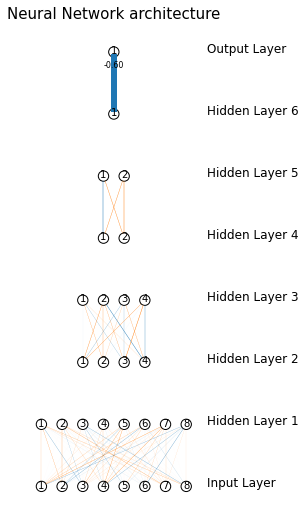

In [ ]:
visualize([8,8,4,2,1], 'weights/ail_xnor_labels/ail_xnor_new', 'ail_xnor', 2, bn=False)

#### Defining weights by hand

XNOR( XNOR( XNOR( 2, 5 ), XNOR( 3, 4 ) ), XNOR( XNOR( 6, 7 ), XNOR( 0, 1 ) ) )

Network with pre-defined weight matrix performance:
val_loss = 0.68152, RMSE =  0.000

================ Layer 0
[[0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]]

================ Layer 2
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

================ Layer 4
[[1. 0.]
 [0. 1.]]

================ Layer 6
[[1.]]



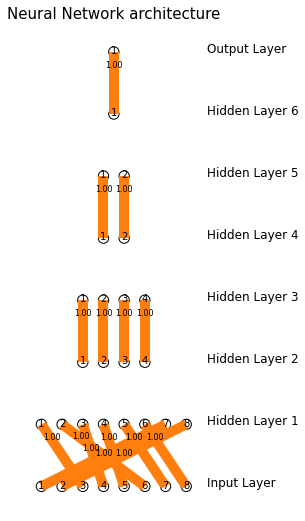

In [ ]:
print(label_function)
print()
print("Network with pre-defined weight matrix performance:")
new_weight_dict = change_state_dict(model, 1.)
evaluate_model(new_weight_dict, nested_val_dataset, bn=False, binary=False)
print()
visualize([8,8,4,2,1], None, 'ail_xnor', 2, state_dict=new_weight_dict, bn=False)

#### Adjusting input distribution and re-running

Labelling function: XNOR( XNOR( XNOR( 2, 5 ), XNOR( 3, 4 ) ), XNOR( XNOR( 6, 7 ), XNOR( 0, 1 ) ) )



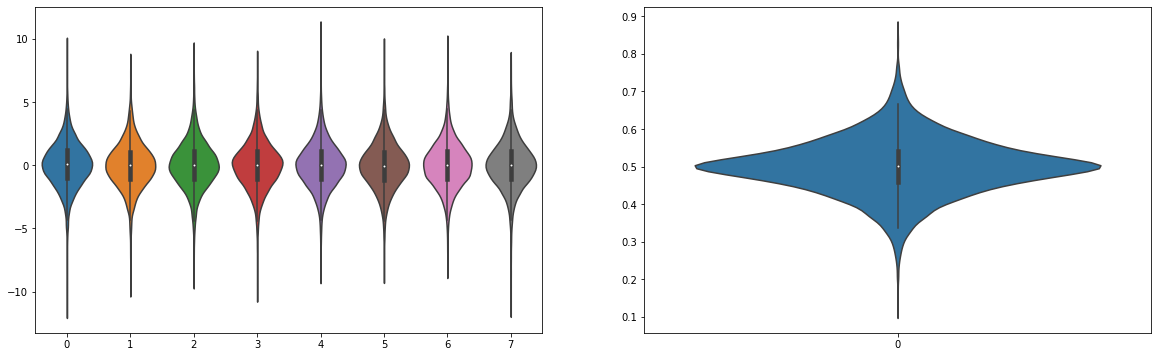

In [13]:
seed = 42
label_function = Xnor_Custom(nested_operations=3, seed=seed, input_as_logit=True, binary=False)
nested_train_dataset = MappingDataset(label_function, num_samples=10000, 
                                      seed=seed, input_as_logit=True, uniform_inputs=False)
nested_val_dataset = MappingDataset(label_function, num_samples=5000, 
                                    seed=seed, input_as_logit=True, uniform_inputs=False)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6), squeeze=False)

sns.violinplot(data=nested_train_dataset.inputs, ax=ax[0][0])
sns.violinplot(data=nested_train_dataset.labels, ax=ax[0][1])

Labelling function: XNOR( XNOR( XNOR( 2, 5 ), XNOR( 3, 4 ) ), XNOR( XNOR( 6, 7 ), XNOR( 0, 1 ) ) )



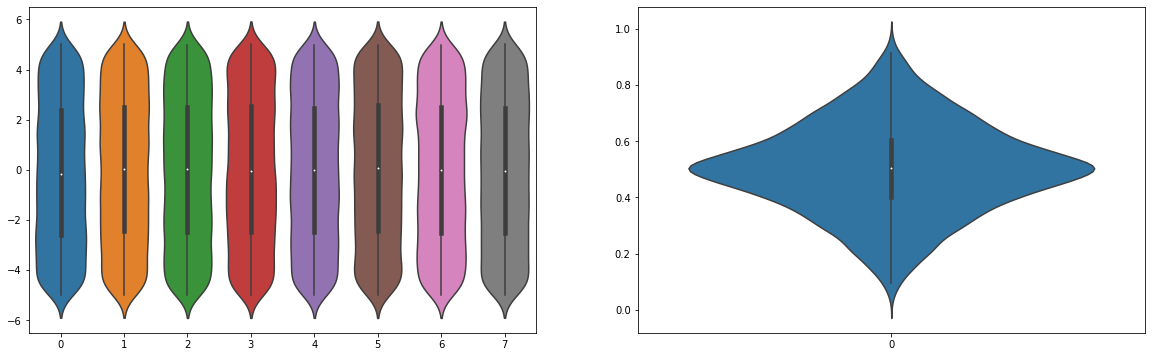

In [14]:
seed = 42
label_function = Xnor_Custom(nested_operations=3, seed=seed, input_as_logit=True, binary=False)
nested_train_dataset = MappingDataset(label_function, num_samples=10000, 
                                      seed=seed, input_as_logit=True, uniform_inputs=True)
nested_val_dataset = MappingDataset(label_function, num_samples=5000, 
                                    seed=seed, input_as_logit=True, uniform_inputs=True)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6), squeeze=False)

sns.violinplot(data=nested_train_dataset.inputs, ax=ax[0][0])
sns.violinplot(data=nested_train_dataset.labels, ax=ax[0][1])

###### ail_xnor

**With Weight Decay**

In [ ]:
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 400})')
model = MLP([8,8,8,8,1], 'ail_xnor', bn=False)
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=100, 
            bs=64, max_lr=0.01, output_dir='weights/ail_xnor_labels_uniform_inputs/',
            verbose=True, label='new', binary=False)

========== Model Setup ==========
Activation Function: ail_xnor
p = 1, k = 2, g = 1
ModuleList(
  (0): Linear(in_features=8, out_features=8, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=4, out_features=8, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=4, out_features=8, bias=True)
  )
  (3): Linear(in_features=4, out_features=1, bias=True)
)
Batch norm OFF
Shuffle map 0: size 8
Shuffle map 1: size 8
Shuffle map 2: size 8

--------------
Start training
--------------
Epoch:   1/ 100 | LR = 0.00043 | train_loss = 0.69466, RMSE =  0.164 | val_loss = 0.69385, RMSE =   0.164 | time = 0.644s
  Sample from validation set:
    Input: [-0.3772  3.043   2.6201 -1.5995 -0.5654 -2.0175 -4.2285  0.0487]
    Output: [0.49052528]
    Target: [0.48783377]

Epoch:   2/ 100 | LR = 0.00050 | train_loss = 0.69347, RMSE =  0.162 | val_loss = 0.69325, RMSE =   0.163 | time = 0.623s
  Sample from validation set:
    Input: [-2.8682  0.2865  2.178   3.2034 -3.5177  4.5909  0.3085  

================ Layer 0
[[ 0.3481626   0.39056897  0.44732508  0.294218    0.13832776 -0.4624676
  -0.25272262  0.33147416]
 [-0.38176778 -0.412012   -0.41452232 -0.3141516  -0.19717188  0.4776808
  -0.24043436  0.30867735]
 [ 0.35986888  0.32164553 -0.3159216  -0.32031694  0.20051597  0.44742572
   0.45338035 -0.11360519]
 [-0.47476858  0.38129938  0.3604948   0.32673648 -0.40548286  0.08630217
   0.28751066 -0.37287542]
 [ 0.42643973 -0.3938051  -0.35074058 -0.31149885  0.3882439  -0.05135114
  -0.27379355  0.39618212]
 [ 0.41480744 -0.42620933  0.3718062   0.32881618 -0.41994172 -0.00874038
   0.28475356 -0.38251218]
 [ 0.37596297  0.37884554  0.11502287  0.52014345  0.231126   -0.43395177
  -0.26158392  0.3874048 ]
 [ 0.45590383 -0.37921482  0.33982638  0.31367025 -0.39842084 -0.02015462
   0.2801217  -0.39632133]]

================ Layer 2
[[ 0.4095653  -0.26694366 -0.18146722  0.43161917  0.05017883  0.01853041
   0.51508635 -0.4064107 ]
 [-0.3341846   0.40213114 -0.48356938 -0.

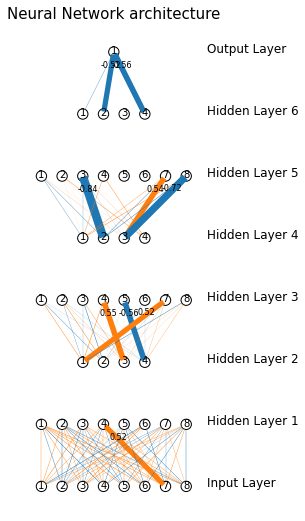

In [ ]:
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 600})')
visualize([8,8,8,8,1], 'weights/ail_xnor_labels_uniform_inputs/ail_xnor_new', 'ail_xnor', 2, bn=False)

In [ ]:
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 400})')
model = MLP([8,16,16,16,1], 'ail_xnor', bn=False)
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=100, 
            bs=64, max_lr=0.01, output_dir='weights/ail_xnor_labels_uniform_inputs/',
            verbose=True, label="new_2x", binary=False)

========== Model Setup ==========
Activation Function: ail_xnor
p = 1, k = 2, g = 1
ModuleList(
  (0): Linear(in_features=8, out_features=16, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=8, out_features=16, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=8, out_features=16, bias=True)
  )
  (3): Linear(in_features=8, out_features=1, bias=True)
)
Batch norm OFF
Shuffle map 0: size 16
Shuffle map 1: size 16
Shuffle map 2: size 16

--------------
Start training
--------------
Epoch:   1/ 100 | LR = 0.00043 | train_loss = 0.69833, RMSE =  0.170 | val_loss = 0.69423, RMSE =   0.165 | time = 0.628s
  Sample from validation set:
    Input: [ 1.3324  2.0318  0.4453  1.0411 -2.2152  2.6837 -0.7495 -4.5033]
    Output: [0.53305936]
    Target: [0.3904679]

Epoch:   2/ 100 | LR = 0.00050 | train_loss = 0.69393, RMSE =  0.163 | val_loss = 0.69330, RMSE =   0.163 | time = 0.631s
  Sample from validation set:
    Input: [ 2.3334  4.0192  0.6172  2.2325 -3.7798  3.5074  3.6

================ Layer 0
[[ 8.46597715e-04 -1.04924245e-03  6.07234895e-01  2.73382266e-05
   3.56049122e-06  3.00345675e-07  1.20985089e-03 -9.67689557e-04
   4.81676434e-05 -2.10700644e-04 -1.47372804e-04 -8.04674288e-04
  -1.08230487e-03 -9.73467890e-04 -2.90004755e-06  8.19984234e-06]
 [-4.90042428e-03 -1.58377958e-03 -2.24569594e-05 -6.07310832e-01
   1.47669925e-05  5.72998772e-07 -6.09877643e-05  2.53582140e-03
  -1.17306758e-04 -2.44439754e-04  4.28051659e-04 -9.04802349e-04
  -1.84278842e-03  3.74971679e-03 -8.55018334e-06 -3.10985070e-06]
 [ 7.09329769e-02 -3.23138908e-02  6.77259641e-06 -9.90598528e-06
   5.03350611e-06 -6.19901836e-01  1.22615941e-01  1.89870372e-02
  -2.58204353e-04  4.22314151e-05  1.10319105e-03  4.91933781e-04
  -1.07770050e-02  1.31032243e-01 -5.96899517e-05 -5.95152014e-05]
 [-8.94817635e-02  5.07483780e-02 -5.50081313e-06  1.67321286e-05
  -3.42686781e-06 -2.25557851e-05 -1.13998391e-01 -3.50816250e-02
   4.85242985e-04  7.96251788e-06 -1.89995591e-0

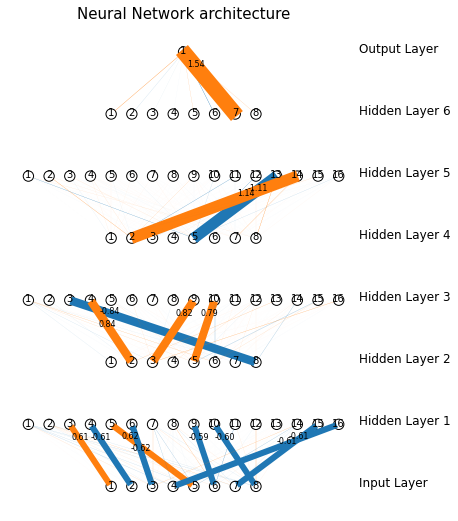

In [ ]:
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 600})')
visualize([8,16,16,16,1], 'weights/ail_xnor_labels_uniform_inputs/ail_xnor_new_2x', 'ail_xnor', 2, bn=False)

**Without Weight Decay**

In [ ]:
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 400})')
model = MLP([8,8,8,8,1], 'ail_xnor', bn=False)
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=100, 
            bs=64, max_lr=0.01, output_dir='weights/ail_xnor_labels_uniform_inputs/',
            verbose=True, label="no_wd", binary=False, wd=False)

========== Model Setup ==========
Activation Function: ail_xnor
p = 1, k = 2, g = 1
ModuleList(
  (0): Linear(in_features=8, out_features=8, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=4, out_features=8, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=4, out_features=8, bias=True)
  )
  (3): Linear(in_features=4, out_features=1, bias=True)
)
Batch norm OFF
Shuffle map 0: size 8
Shuffle map 1: size 8
Shuffle map 2: size 8

--------------
Start training
--------------
Epoch:   1/ 100 | LR = 0.00043 | train_loss = 0.69676, RMSE =  0.167 | val_loss = 0.69442, RMSE =   0.165 | time = 0.618s
  Sample from validation set:
    Input: [ 4.4691 -2.5001  4.5001  0.6085 -0.2982 -3.5546  1.8095 -1.4391]
    Output: [0.48603994]
    Target: [0.5740051]

Epoch:   2/ 100 | LR = 0.00050 | train_loss = 0.69378, RMSE =  0.163 | val_loss = 0.69316, RMSE =   0.163 | time = 0.624s
  Sample from validation set:
    Input: [-3.386   2.1653  2.8446 -1.6944 -0.1793 -1.0092 -0.7178  3

In [ ]:
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 400})')
model = MLP([8,16,16,16,1], 'ail_xnor', bn=False)
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=100, 
            bs=64, max_lr=0.01, output_dir='weights/ail_xnor_labels_uniform_inputs/',
            verbose=True, label="no_wd_2x", binary=False, wd=False)

========== Model Setup ==========
Activation Function: ail_xnor
p = 1, k = 2, g = 1
ModuleList(
  (0): Linear(in_features=8, out_features=16, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=8, out_features=16, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=8, out_features=16, bias=True)
  )
  (3): Linear(in_features=8, out_features=1, bias=True)
)
Batch norm OFF
Shuffle map 0: size 16
Shuffle map 1: size 16
Shuffle map 2: size 16

--------------
Start training
--------------
Epoch:   1/ 100 | LR = 0.00043 | train_loss = 0.69405, RMSE =  0.163 | val_loss = 0.69299, RMSE =   0.163 | time = 0.654s
  Sample from validation set:
    Input: [ 1.3992  1.978  -4.3261 -1.2068  4.8509 -0.6327 -2.7266  2.1774]
    Output: [0.5066099]
    Target: [0.65310436]

Epoch:   2/ 100 | LR = 0.00050 | train_loss = 0.69315, RMSE =  0.162 | val_loss = 0.69271, RMSE =   0.163 | time = 0.620s
  Sample from validation set:
    Input: [-4.1643  0.536  -2.837   0.7907 -2.4755  3.8973  1.7

In [ ]:
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 400})')
model = MLP([8,32,32,32,1], 'ail_xnor', bn=False)
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=100, 
            bs=64, max_lr=0.01, output_dir='weights/ail_xnor_labels_uniform_inputs/',
            verbose=True, label="no_wd_3x", binary=False, wd=False)

========== Model Setup ==========
Activation Function: ail_xnor
p = 1, k = 2, g = 1
ModuleList(
  (0): Linear(in_features=8, out_features=32, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=16, out_features=32, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=16, out_features=32, bias=True)
  )
  (3): Linear(in_features=16, out_features=1, bias=True)
)
Batch norm OFF
Shuffle map 0: size 32
Shuffle map 1: size 32
Shuffle map 2: size 32

--------------
Start training
--------------
Epoch:   1/ 100 | LR = 0.00043 | train_loss = 0.69405, RMSE =  0.163 | val_loss = 0.69283, RMSE =   0.163 | time = 0.626s
  Sample from validation set:
    Input: [ 1.2965 -2.6789  0.3474 -1.5303 -4.8607 -4.6797 -3.9969  2.07  ]
    Output: [0.5259622]
    Target: [0.4140205]

Epoch:   2/ 100 | LR = 0.00050 | train_loss = 0.69253, RMSE =  0.161 | val_loss = 0.69193, RMSE =   0.161 | time = 0.622s
  Sample from validation set:
    Input: [-4.8094 -1.1775 -3.7605  0.7053  2.3008 -4.6767 -2

================ Layer 0
[[ 4.24973339e-01  3.30925547e-02  9.76317823e-01  4.33115840e-01
  -8.10028613e-03 -6.72470212e-01  4.72987583e-03  4.78239218e-03
  -2.50109673e-01 -2.04581209e-02  4.94528003e-03  5.00141457e-03
  -1.09551215e+00  1.00836527e+00 -1.15505266e+00 -1.23733902e+00
   3.85408312e-05 -4.15823124e-05  7.64192522e-01 -6.67843997e-01
   7.14500621e-03  7.13837333e-03 -1.59067714e+00  7.77112395e-02
   4.17625248e-01 -3.67721468e-02  2.38954226e-06  2.59371063e-05
  -1.24416304e+00 -2.37032667e-01  1.21383525e-01 -5.23393929e-01]
 [ 5.51558554e-01 -5.57104945e-01 -1.61636636e-01  3.11437882e-02
  -6.34845614e-01 -5.98050117e-01 -6.93239388e-04 -5.82277717e-04
  -4.34388995e-01 -3.09337109e-01 -6.96245406e-04 -7.10640626e-04
   2.56087005e-01  2.59114176e-01 -2.38603130e-01  2.34617844e-01
  -9.87856674e-06  2.07374615e-05 -2.98751086e-01 -2.85612404e-01
  -9.85538354e-04 -9.78198601e-04  1.47650731e-04  2.84608593e-03
   6.57918900e-02  3.65128845e-01 -2.17141724e+00 

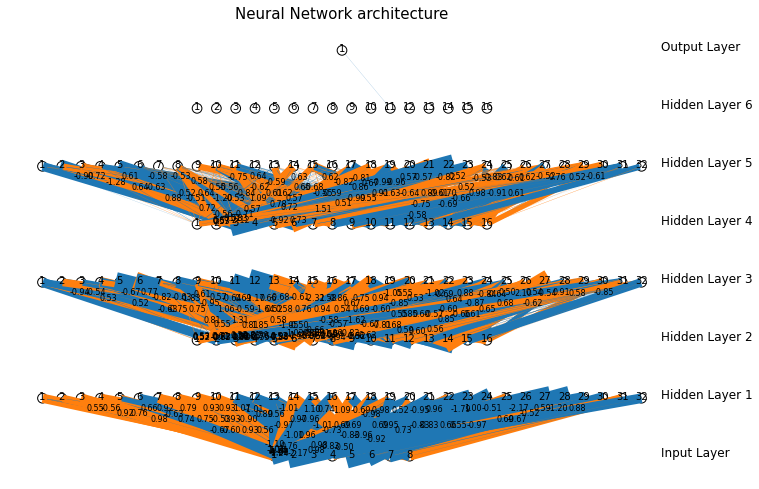

In [ ]:
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 600})')
visualize([8,32,32,32,1], 'weights/ail_xnor_labels_uniform_inputs/ail_xnor_no_wd_3x', 'ail_xnor', 2, bn=False)

In [ ]:
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 400})')
model = MLP([8,32,32,32,1], 'ail_xnor', bn=False)
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=100, 
            bs=64, max_lr=0.01, output_dir='weights/ail_xnor_labels_uniform_inputs/',
            verbose=True, label="no_wd_3x_2", binary=False, wd=False)

========== Model Setup ==========
Activation Function: ail_xnor
p = 1, k = 2, g = 1
ModuleList(
  (0): Linear(in_features=8, out_features=32, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=16, out_features=32, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=16, out_features=32, bias=True)
  )
  (3): Linear(in_features=16, out_features=1, bias=True)
)
Batch norm OFF
Shuffle map 0: size 32
Shuffle map 1: size 32
Shuffle map 2: size 32

--------------
Start training
--------------
Epoch:   1/ 100 | LR = 0.00043 | train_loss = 0.69416, RMSE =  0.163 | val_loss = 0.69272, RMSE =   0.162 | time = 0.638s
  Sample from validation set:
    Input: [ 3.7706 -2.7689 -1.1606  2.4599  3.6287  2.6094 -1.2176  4.2097]
    Output: [0.51910627]
    Target: [0.23855703]

Epoch:   2/ 100 | LR = 0.00050 | train_loss = 0.69269, RMSE =  0.161 | val_loss = 0.69192, RMSE =   0.161 | time = 0.644s
  Sample from validation set:
    Input: [ 3.5513  0.5659 -3.2336 -1.8448  3.5361 -0.2918 

================ Layer 0
[[-3.4513912e-01  5.0915623e-01  6.1279017e-05 -2.3876023e-04
   8.0197069e-06 -1.4308299e-05  3.2225583e-02 -3.6916211e-03
  -9.3966357e-02 -2.1997202e-02 -6.9653011e-05 -1.0180526e-04
  -3.7670538e-01 -4.6643278e-01 -3.7184770e-03 -1.6739302e+00
  -4.1123536e-01 -7.5467475e-02 -2.6298534e-02 -9.6893197e-01
  -1.9240184e-03 -2.1253915e-03 -9.1007829e-02 -5.2285331e-01
  -4.1916161e-03 -5.7709059e-03 -2.4416132e-03 -7.2605407e-04
   2.0591954e-03 -2.1075269e-03  3.8632281e-02 -9.7650491e-02]
 [ 1.8941857e-01 -5.8566409e-01 -1.7940241e+00 -2.2447938e-02
   1.9400042e-05 -2.9915745e-05 -9.8320538e-01 -4.3670511e-01
   1.3418159e+00  4.4762266e-01  1.7225252e+00 -7.4994250e-04
  -9.9641517e-02  1.2553362e-02 -3.1935089e-04 -2.9766432e-04
  -5.3385752e-01  5.1887250e-01 -2.4072283e-03  2.1123968e-03
   4.1767374e-01  4.1732305e-01  1.9007994e-01 -6.3050471e-02
   8.1796825e-01  8.1394076e-01  1.1515834e+00 -5.1379615e-01
  -4.5021757e-01  4.5014074e-01  2.8063849e-

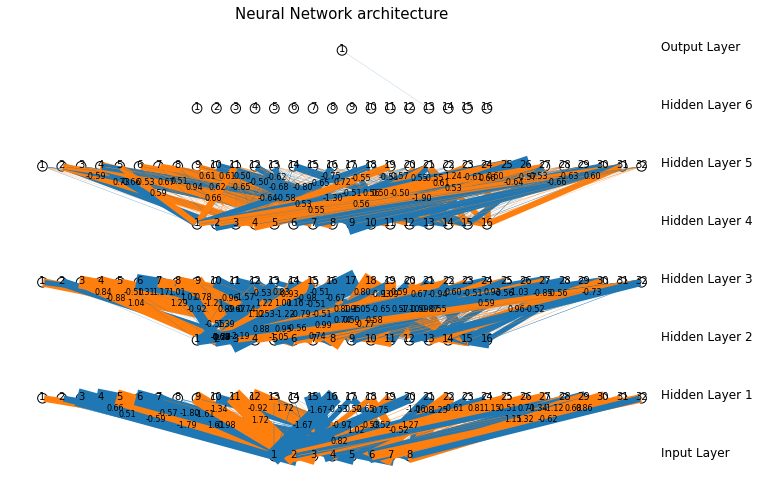

In [ ]:
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 600})')
visualize([8,32,32,32,1], 'weights/ail_xnor_labels_uniform_inputs/ail_xnor_no_wd_3x_2', 'ail_xnor', 2, bn=False)

###### relu

In [15]:
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 400})')
model = MLP([8,8,8,8,1], 'relu', k=1, bn=False)
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=100, 
            bs=64, max_lr=0.01, output_dir='weights/ail_xnor_labels_uniform_inputs/',
            verbose=True, label='1', binary=False)

========== Model Setup ==========
Activation Function: relu
p = 1, k = 1, g = 1
ModuleList(
  (0): Linear(in_features=8, out_features=8, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=8, out_features=8, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=8, out_features=8, bias=True)
  )
  (3): Linear(in_features=8, out_features=1, bias=True)
)
Batch norm OFF
Shuffle map 0: size 8
Shuffle map 1: size 8
Shuffle map 2: size 8

--------------
Start training
--------------
Epoch:   1/ 100 | LR = 0.00043 | train_loss = 0.69514, RMSE =  0.165 | val_loss = 0.69363, RMSE =   0.164 | time = 0.623s
  Sample from validation set:
    Input: [ 4.9835  0.9357 -3.1867  3.0847  1.6362 -0.2031  2.1717 -0.4595]
    Output: [0.48249495]
    Target: [0.44940317]

Epoch:   2/ 100 | LR = 0.00050 | train_loss = 0.69347, RMSE =  0.162 | val_loss = 0.69332, RMSE =   0.163 | time = 0.477s
  Sample from validation set:
    Input: [ 0.7686  4.9096 -2.4316 -0.6456 -1.8568 -4.9752  1.1158  3.00

================ Layer 0
[[ 0.32227007  0.21656409  0.3082311   0.47737706  0.3003187   0.43191504
   0.36180636  0.34526953]
 [-0.12844846  0.17414685  0.27005437  0.3313143   0.32478437 -0.28396362
   0.3688742   0.31712452]
 [ 0.24625362 -0.21210364  0.30689806  0.44495118  0.30796817  0.35122573
   0.36648318  0.34908932]
 [ 0.25818533  0.19572668 -0.19346     0.43205816  0.28249353  0.40987185
   0.20041244  0.4006021 ]
 [ 0.26036423 -0.18213506 -0.27115175  0.41937798 -0.27296013  0.3527809
  -0.3881345   0.3471789 ]
 [-0.25745222  0.2101586   0.24334782 -0.40965143  0.2581585  -0.4154922
   0.3674794  -0.33499452]
 [-0.22901541 -0.21616432  0.29248747 -0.41417807  0.284337   -0.34256348
   0.3327824  -0.34322074]
 [ 0.27161238 -0.19072595  0.3408457  -0.2833668  -0.17948475 -0.2743099
   0.23280197  0.23995319]]

================ Layer 2
[[ 4.9208283e-02 -9.8238480e-33  4.6070513e-01 -2.5419554e-42
  -3.1141378e-03 -5.7188392e-41 -5.6254764e-24 -4.7481939e-02]
 [ 1.1466109e-01 -

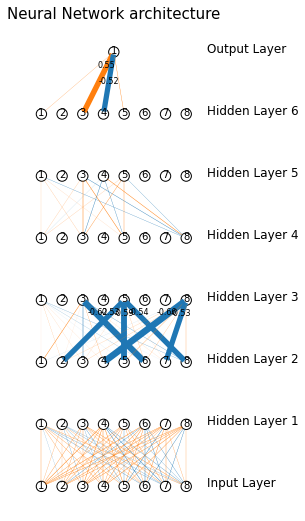

In [16]:
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 600})')
visualize([8,8,8,8,1], 'weights/ail_xnor_labels_uniform_inputs/relu_1', 'relu', 1, bn=False)

In [17]:
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 400})')
model = MLP([8,16,16,16,1], 'relu', k=1, bn=False)
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=100, 
            bs=64, max_lr=0.01, output_dir='weights/ail_xnor_labels_uniform_inputs/',
            verbose=True, label='2', binary=False)

========== Model Setup ==========
Activation Function: relu
p = 1, k = 1, g = 1
ModuleList(
  (0): Linear(in_features=8, out_features=16, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=16, out_features=16, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=16, out_features=16, bias=True)
  )
  (3): Linear(in_features=16, out_features=1, bias=True)
)
Batch norm OFF
Shuffle map 0: size 16
Shuffle map 1: size 16
Shuffle map 2: size 16

--------------
Start training
--------------
Epoch:   1/ 100 | LR = 0.00043 | train_loss = 0.69339, RMSE =  0.162 | val_loss = 0.69302, RMSE =   0.163 | time = 0.471s
  Sample from validation set:
    Input: [ 3.6837 -3.3042  2.6455  1.0548 -2.6046 -0.8825 -2.2243  4.6991]
    Output: [0.49840134]
    Target: [0.7073455]

Epoch:   2/ 100 | LR = 0.00050 | train_loss = 0.69314, RMSE =  0.162 | val_loss = 0.69297, RMSE =   0.163 | time = 0.492s
  Sample from validation set:
    Input: [-2.1022  0.9867  3.8196  0.5645 -2.8315 -3.7785  0.18

In [18]:
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 400})')
model = MLP([8,32,32,32,1], 'relu', k=1, bn=False)
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=100, 
            bs=64, max_lr=0.01, output_dir='weights/ail_xnor_labels_uniform_inputs/',
            verbose=True, label='4', binary=False)

========== Model Setup ==========
Activation Function: relu
p = 1, k = 1, g = 1
ModuleList(
  (0): Linear(in_features=8, out_features=32, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=32, out_features=32, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=32, out_features=32, bias=True)
  )
  (3): Linear(in_features=32, out_features=1, bias=True)
)
Batch norm OFF
Shuffle map 0: size 32
Shuffle map 1: size 32
Shuffle map 2: size 32

--------------
Start training
--------------
Epoch:   1/ 100 | LR = 0.00043 | train_loss = 0.69370, RMSE =  0.163 | val_loss = 0.69303, RMSE =   0.163 | time = 0.496s
  Sample from validation set:
    Input: [ 0.1783  3.1525 -2.0486 -0.5433  2.7002 -4.5772 -1.1053 -0.8174]
    Output: [0.5063046]
    Target: [0.4555337]

Epoch:   2/ 100 | LR = 0.00050 | train_loss = 0.69316, RMSE =  0.162 | val_loss = 0.69303, RMSE =   0.163 | time = 0.486s
  Sample from validation set:
    Input: [-1.5717 -1.8568 -2.8337 -0.6267  3.2003  4.7144 -4.356

In [19]:
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 400})')
model = MLP([8,64,64,64,1], 'relu', k=1, bn=False)
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=100, 
            bs=64, max_lr=0.01, output_dir='weights/ail_xnor_labels_uniform_inputs/',
            verbose=True, label='8', binary=False)

========== Model Setup ==========
Activation Function: relu
p = 1, k = 1, g = 1
ModuleList(
  (0): Linear(in_features=8, out_features=64, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
  )
  (3): Linear(in_features=64, out_features=1, bias=True)
)
Batch norm OFF
Shuffle map 0: size 64
Shuffle map 1: size 64
Shuffle map 2: size 64

--------------
Start training
--------------
Epoch:   1/ 100 | LR = 0.00043 | train_loss = 0.69355, RMSE =  0.162 | val_loss = 0.69303, RMSE =   0.163 | time = 0.495s
  Sample from validation set:
    Input: [ 3.1561  0.8956  2.0683 -4.0511 -0.7616  1.561   3.896   3.6976]
    Output: [0.49635282]
    Target: [0.68170094]

Epoch:   2/ 100 | LR = 0.00050 | train_loss = 0.69295, RMSE =  0.161 | val_loss = 0.69259, RMSE =   0.162 | time = 0.475s
  Sample from validation set:
    Input: [-0.9039  4.7414  0.5066 -2.9094 -0.2501 -4.3176  0.7

In [22]:
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 400})')
model = MLP([8,128,128,128,1], 'relu', k=1, bn=False)
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=100, 
            bs=64, max_lr=0.001, output_dir='weights/ail_xnor_labels_uniform_inputs/',
            verbose=True, label='16', binary=False)

========== Model Setup ==========
Activation Function: relu
p = 1, k = 1, g = 1
ModuleList(
  (0): Linear(in_features=8, out_features=128, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
  )
  (3): Linear(in_features=128, out_features=1, bias=True)
)
Batch norm OFF
Shuffle map 0: size 128
Shuffle map 1: size 128
Shuffle map 2: size 128

--------------
Start training
--------------
Epoch:   1/ 100 | LR = 0.00004 | train_loss = 0.69406, RMSE =  0.163 | val_loss = 0.69327, RMSE =   0.163 | time = 0.487s
  Sample from validation set:
    Input: [ 2.2392 -0.4272 -0.4817  2.8087 -4.7897  4.843  -0.5541  0.974 ]
    Output: [0.48639953]
    Target: [0.605201]

Epoch:   2/ 100 | LR = 0.00005 | train_loss = 0.69324, RMSE =  0.162 | val_loss = 0.69297, RMSE =   0.163 | time = 0.492s
  Sample from validation set:
    Input: [-4.6203  3.329  -4.1208 -2.0314  1.8345  2.46

In [23]:
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 400})')
model = MLP([8,256,256,256,1], 'relu', k=1, bn=False)
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=100, 
            bs=64, max_lr=0.001, output_dir='weights/ail_xnor_labels_uniform_inputs/',
            verbose=True, label='32', binary=False)

========== Model Setup ==========
Activation Function: relu
p = 1, k = 1, g = 1
ModuleList(
  (0): Linear(in_features=8, out_features=256, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=256, out_features=256, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=256, out_features=256, bias=True)
  )
  (3): Linear(in_features=256, out_features=1, bias=True)
)
Batch norm OFF
Shuffle map 0: size 256
Shuffle map 1: size 256
Shuffle map 2: size 256

--------------
Start training
--------------
Epoch:   1/ 100 | LR = 0.00004 | train_loss = 0.69374, RMSE =  0.163 | val_loss = 0.69261, RMSE =   0.163 | time = 0.516s
  Sample from validation set:
    Input: [ 4.9259  2.2359  0.8152 -1.3874  2.7743  1.3594  2.6885  1.1223]
    Output: [0.49505132]
    Target: [0.3067731]

Epoch:   2/ 100 | LR = 0.00005 | train_loss = 0.69285, RMSE =  0.161 | val_loss = 0.69225, RMSE =   0.162 | time = 0.481s
  Sample from validation set:
    Input: [-4.1053 -3.8668 -1.0923  2.3894 -3.7602 -4.1

In [25]:
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 400})')
model = MLP([8,512,512,512,1], 'relu', k=1, bn=False)
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=100, 
            bs=64, max_lr=0.001, output_dir='weights/ail_xnor_labels_uniform_inputs/',
            verbose=True, label='64', binary=False)

========== Model Setup ==========
Activation Function: relu
p = 1, k = 1, g = 1
ModuleList(
  (0): Linear(in_features=8, out_features=512, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=512, out_features=512, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=512, out_features=512, bias=True)
  )
  (3): Linear(in_features=512, out_features=1, bias=True)
)
Batch norm OFF
Shuffle map 0: size 512
Shuffle map 1: size 512
Shuffle map 2: size 512

--------------
Start training
--------------
Epoch:   1/ 100 | LR = 0.00000 | train_loss = 0.69452, RMSE =  0.164 | val_loss = 0.69327, RMSE =   0.163 | time = 0.500s
  Sample from validation set:
    Input: [-1.5765 -1.4967  1.9022 -2.508  -3.4466 -1.6061 -0.2978 -2.1499]
    Output: [0.4958938]
    Target: [0.42609912]

Epoch:   2/ 100 | LR = 0.00001 | train_loss = 0.69317, RMSE =  0.162 | val_loss = 0.69295, RMSE =   0.163 | time = 0.506s
  Sample from validation set:
    Input: [ 2.4404  0.3801  4.2849  4.0797 -1.36    3.8

In [29]:
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 400})')
model = MLP([8,1024,1024,1024,1], 'relu', k=1, bn=False)
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=100, 
            bs=64, max_lr=0.0001, output_dir='weights/ail_xnor_labels_uniform_inputs/',
            verbose=True, label='128', binary=False)

========== Model Setup ==========
Activation Function: relu
p = 1, k = 1, g = 1
ModuleList(
  (0): Linear(in_features=8, out_features=1024, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (3): Linear(in_features=1024, out_features=1, bias=True)
)
Batch norm OFF
Shuffle map 0: size 1024
Shuffle map 1: size 1024
Shuffle map 2: size 1024

--------------
Start training
--------------
Epoch:   1/ 100 | LR = 0.00000 | train_loss = 0.69353, RMSE =  0.162 | val_loss = 0.69272, RMSE =   0.163 | time = 0.524s
  Sample from validation set:
    Input: [-1.6362  0.1511 -2.8275 -2.0769 -4.9071 -4.3587 -1.2625 -4.2567]
    Output: [0.49575976]
    Target: [0.4622929]

Epoch:   2/ 100 | LR = 0.00001 | train_loss = 0.69289, RMSE =  0.161 | val_loss = 0.69235, RMSE =   0.162 | time = 0.502s
  Sample from validation set:
    Input: [ 2.198  -4.99    2.4447  2.5046 -3.

In [31]:
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 400})')
model = MLP([8,64,64,64,1], 'relu', k=1, bn=False)
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=100, 
            bs=64, max_lr=0.001, output_dir='weights/ail_xnor_labels_uniform_inputs/',
            verbose=True, label='8', binary=False)

========== Model Setup ==========
Activation Function: relu
p = 1, k = 1, g = 1
ModuleList(
  (0): Linear(in_features=8, out_features=64, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
  )
  (3): Linear(in_features=64, out_features=1, bias=True)
)
Batch norm OFF
Shuffle map 0: size 64
Shuffle map 1: size 64
Shuffle map 2: size 64

--------------
Start training
--------------
Epoch:   1/ 100 | LR = 0.00004 | train_loss = 0.69434, RMSE =  0.164 | val_loss = 0.69332, RMSE =   0.164 | time = 0.499s
  Sample from validation set:
    Input: [ 1.6904  4.1855  3.3112  0.2705  3.5259  3.4479 -0.8256  2.8734]
    Output: [0.5180914]
    Target: [0.43278092]

Epoch:   2/ 100 | LR = 0.00005 | train_loss = 0.69337, RMSE =  0.162 | val_loss = 0.69318, RMSE =   0.163 | time = 0.471s
  Sample from validation set:
    Input: [-4.8787  4.3827  3.5028  0.7268  2.8302  4.9023 -1.54

#### Pre-initializing weights to be close to optimal

###### n=0 (control)

XNOR( XNOR( XNOR( 2, 5 ), XNOR( 3, 4 ) ), XNOR( XNOR( 6, 7 ), XNOR( 0, 1 ) ) )

Network with pre-defined weight matrix performance:
val_loss = 0.63660, RMSE =  0.000

================ Layer 0
[[0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]]

================ Layer 2
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

================ Layer 4
[[1. 0.]
 [0. 1.]]

================ Layer 6
[[1.]]



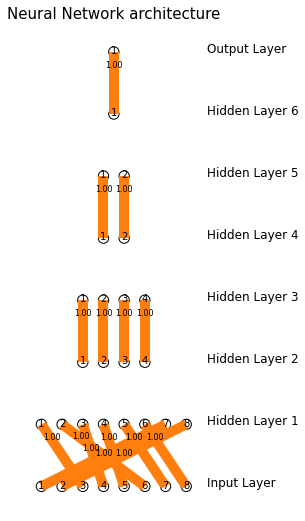

In [ ]:
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 600})')
model = MLP([8,8,4,2,1], 'ail_xnor', bn=False, verbose=False)
print(label_function)
print()
print("Network with pre-defined weight matrix performance:")
new_weight_dict = change_state_dict(model, n=0, p=1.)
evaluate_model(new_weight_dict, nested_val_dataset, bn=False, binary=False)
print()
visualize([8,8,4,2,1], None, 'ail_xnor', 2, state_dict=new_weight_dict, bn=False)

In [ ]:
seed = 42
label_function = Xnor_Custom(nested_operations=3, seed=seed, input_as_logit=True, binary=False)
nested_train_dataset = MappingDataset(label_function, num_samples=10000, 
                                      seed=seed, input_as_logit=True, uniform_inputs=True)
nested_val_dataset = MappingDataset(label_function, num_samples=5000, 
                                    seed=seed, input_as_logit=True, uniform_inputs=True)
  
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 400})')
model = MLP([8,8,4,2,1], 'ail_xnor', bn=False)
model.load_state_dict(new_weight_dict)
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=100, 
            bs=64, max_lr=0.01, output_dir='weights/ail_xnor_labels_uniform_preinit/',
            verbose=True, label='0', binary=False)

Labelling function: XNOR( XNOR( XNOR( 2, 5 ), XNOR( 3, 4 ) ), XNOR( XNOR( 6, 7 ), XNOR( 0, 1 ) ) )

========== Model Setup ==========
Activation Function: ail_xnor
p = 1, k = 2, g = 1
ModuleList(
  (0): Linear(in_features=8, out_features=8, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=True)
  )
  (3): Linear(in_features=1, out_features=1, bias=True)
)
Batch norm OFF
Shuffle map 0: size 8
Shuffle map 1: size 4
Shuffle map 2: size 2

--------------
Start training
--------------
Epoch:   1/ 100 | LR = 0.00043 | train_loss = 0.63747, RMSE =  0.001 | val_loss = 0.63615, RMSE =   0.001 | time = 0.666s
  Sample from validation set:
    Input: [-2.5744  2.1753  0.5131 -4.7114 -3.5419  4.3841  2.243  -2.9503]
    Output: [0.6253372]
    Target: [0.6255234]

Epoch:   2/ 100 | LR = 0.00050 | train_loss = 0.63751, RMSE =  0.001 | val_loss = 0.63670, RMSE =   0.001 | time = 0.652s
 

================ Layer 0
[[-5.88471776e-05 -1.06593880e-05 -3.20662839e-05  1.05214694e-05
   1.41089386e-05  2.50758367e-05  5.95773280e-01 -1.38317328e-05]
 [ 1.98894340e-05  1.64829326e-05  1.76051635e-05  5.02746007e-05
   4.25019198e-06  2.98912255e-05 -1.48245945e-05  5.95647573e-01]
 [ 5.95465720e-01 -3.66287495e-05  1.53522942e-05  2.68648691e-05
   1.08043332e-05 -5.21677839e-06 -1.10129404e-05  5.03467199e-05]
 [-5.23747949e-05  5.88543298e-05  5.95454037e-01 -4.05237461e-06
  -1.39700287e-05 -4.22697376e-05  6.94827713e-06  1.27688209e-05]
 [-6.99203611e-06 -2.92307759e-05 -1.85991485e-05  5.95466793e-01
  -2.69122520e-05  3.07999580e-05 -1.07128762e-05  4.32275519e-05]
 [-1.44132518e-05  5.95501244e-01 -1.17941754e-05  3.88982444e-05
   3.01891196e-05 -9.73575243e-06  1.40647553e-05 -9.13350868e-06]
 [ 3.10598371e-05  3.27205125e-05 -1.24948765e-05 -5.25192554e-05
   5.95552564e-01 -6.27450208e-06 -5.65282051e-07  9.36709330e-06]
 [ 5.63022240e-06 -1.61338103e-05  5.9224448

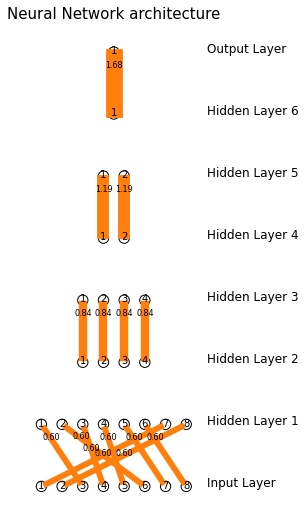

In [ ]:
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 600})')
visualize([8,8,4,2,1], 'weights/ail_xnor_labels_uniform_preinit/ail_xnor_0', 'ail_xnor', 2, bn=False)

###### n=10

XNOR( XNOR( XNOR( 2, 5 ), XNOR( 3, 4 ) ), XNOR( XNOR( 6, 7 ), XNOR( 0, 1 ) ) )

Network with pre-defined weight matrix performance:
val_loss = 0.64265, RMSE =  0.052

================ Layer 0
[[-0.0248674  -0.01109897 -0.02675182 -0.0316897   0.00780401 -0.01919845
   1.          0.02661875]
 [ 0.03016369  0.01473453  0.00461395  0.03135573 -0.01252691 -0.03189759
  -0.00628662  1.        ]
 [ 1.         -0.02808218  0.00403142  0.01528187 -0.01424687 -0.02021378
   0.02819336 -0.02048794]
 [-0.01722043  0.03429354  1.         -0.01382765 -0.00106471 -0.00346139
  -0.02690782  0.03334923]
 [ 0.03407169 -0.01399914 -0.02830371  1.         -0.00339837 -0.03298721
   0.03426374 -0.03115551]
 [ 0.03508158  1.          0.02833623  0.03331722  0.0136758  -0.01671851
   0.02334485  0.02926126]
 [-0.01166859 -0.023492    0.02802923  0.01349575  1.         -0.01643713
   0.00205978  0.02695345]
 [-0.02772674  0.03359894 -0.0308206   0.02216707  0.02061841  1.
  -0.01980727 -0.00322573]]

======

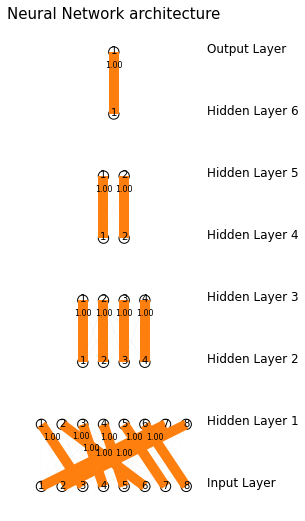

In [ ]:
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 600})')
model = MLP([8,8,4,2,1], 'ail_xnor', bn=False, verbose=False)
print(label_function)
print()
print("Network with pre-defined weight matrix performance:")
new_weight_dict = change_state_dict(model, n=10, p=1.)
evaluate_model(new_weight_dict, nested_val_dataset, bn=False, binary=False)
print()
visualize([8,8,4,2,1], None, 'ail_xnor', 2, state_dict=new_weight_dict, bn=False)

In [ ]:
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 400})')
model = MLP([8,8,4,2,1], 'ail_xnor', bn=False)
model.load_state_dict(new_weight_dict)
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=100, 
            bs=64, max_lr=0.01, output_dir='weights/ail_xnor_labels_uniform_preinit/',
            verbose=True, label='10', binary=False)

========== Model Setup ==========
Activation Function: ail_xnor
p = 1, k = 2, g = 1
ModuleList(
  (0): Linear(in_features=8, out_features=8, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=True)
  )
  (3): Linear(in_features=1, out_features=1, bias=True)
)
Batch norm OFF
Shuffle map 0: size 8
Shuffle map 1: size 4
Shuffle map 2: size 2

--------------
Start training
--------------
Epoch:   1/ 100 | LR = 0.00043 | train_loss = 0.63925, RMSE =  0.028 | val_loss = 0.63680, RMSE =   0.006 | time = 0.675s
  Sample from validation set:
    Input: [-1.0287 -1.9585 -2.8435 -0.9912 -0.3083 -4.4956 -3.4519 -3.2656]
    Output: [0.573237]
    Target: [0.57646424]

Epoch:   2/ 100 | LR = 0.00050 | train_loss = 0.63755, RMSE =  0.003 | val_loss = 0.63639, RMSE =   0.002 | time = 0.657s
  Sample from validation set:
    Input: [-3.3202 -1.5491  0.9007 -4.3711  0.3323  4.6605  1.8786  0.

================ Layer 0
[[-2.49008881e-05  7.13878308e-06 -1.67005237e-05  3.12914312e-06
   1.20189297e-05 -1.82941512e-05  5.95626116e-01 -5.42879134e-05]
 [-4.00608030e-07  1.14716395e-05  2.74917438e-05 -4.43464669e-05
   3.95555298e-06  5.24653551e-05 -2.98582563e-05  5.95627844e-01]
 [ 5.95269322e-01 -6.47209163e-05  3.41481500e-05 -6.05882560e-05
  -7.00984629e-06 -2.02109295e-05  4.11219116e-06 -3.73196381e-05]
 [ 3.59579681e-05 -4.89386584e-05  5.95640004e-01  1.98124399e-05
  -1.35921600e-05  3.70647576e-05  4.11384426e-05 -2.00837385e-05]
 [-1.86944669e-06 -1.04189066e-05 -1.23954260e-05  5.95621943e-01
   1.78969458e-05 -7.05153639e-07 -1.17307100e-05 -2.89991767e-05]
 [ 1.74449087e-05  5.95391035e-01 -2.31639860e-05 -1.43780535e-05
  -5.67191491e-05 -1.33079102e-05  1.34646461e-05  5.36019616e-06]
 [ 1.20982368e-05  1.65295078e-05  3.06685906e-05  4.25926828e-06
   5.95734000e-01 -1.79076997e-05  4.20049837e-05  8.37848256e-06]
 [ 1.36248809e-05 -1.72995879e-05  3.7519581

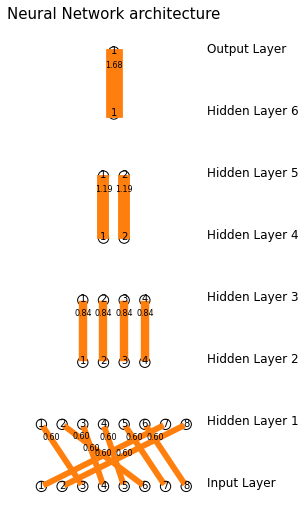

In [ ]:
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 600})')
visualize([8,8,4,2,1], 'weights/ail_xnor_labels_uniform_preinit/ail_xnor_10', 'ail_xnor', 2, bn=False)

###### n=5

XNOR( XNOR( XNOR( 2, 5 ), XNOR( 3, 4 ) ), XNOR( XNOR( 6, 7 ), XNOR( 0, 1 ) ) )

Network with pre-defined weight matrix performance:
val_loss = 0.65080, RMSE =  0.080

================ Layer 0
[[-0.03971457 -0.0638079  -0.06704751  0.02746489  0.01165476 -0.06247015
   1.         -0.04971286]
 [-0.0361455  -0.03546479 -0.01707684 -0.03058644  0.0534152   0.00742682
  -0.00401863  1.        ]
 [ 1.          0.05647021 -0.0569355  -0.04206145 -0.00108932  0.05809263
   0.04533856  0.05880735]
 [-0.02208127  0.03637157  1.          0.00506995  0.05291206  0.01410417
  -0.04629885 -0.00175862]
 [-0.01624959 -0.06271142  0.06540783  1.         -0.01570876 -0.00317091
   0.02254197 -0.05924097]
 [-0.01624386  1.          0.01583917  0.04624502 -0.00338208  0.06889188
  -0.03357694 -0.05083696]
 [-0.0178052   0.06774879  0.02340693 -0.01464816  1.         -0.02568974
   0.04342593 -0.06498258]
 [ 0.04253126 -0.0278412   0.0368796  -0.01467134  0.05506723  1.
   0.03425707 -0.04609468]]

======

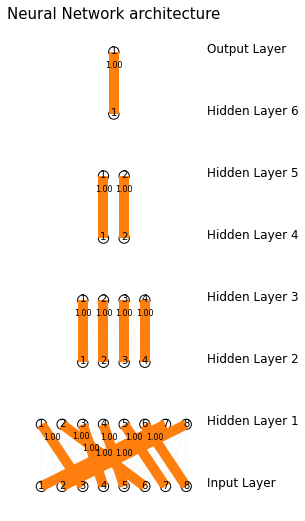

In [ ]:
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 600})')
model = MLP([8,8,4,2,1], 'ail_xnor', bn=False, verbose=False)
print(label_function)
print()
print("Network with pre-defined weight matrix performance:")
new_weight_dict = change_state_dict(model, n=5, p=1.)
evaluate_model(new_weight_dict, nested_val_dataset, bn=False, binary=False)
print()
visualize([8,8,4,2,1], None, 'ail_xnor', 2, state_dict=new_weight_dict, bn=False)

In [ ]:
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 400})')
model = MLP([8,8,4,2,1], 'ail_xnor', bn=False)
model.load_state_dict(new_weight_dict)
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=100, 
            bs=64, max_lr=0.01, output_dir='weights/ail_xnor_labels_uniform_preinit/',
            verbose=True, label='5', binary=False)

========== Model Setup ==========
Activation Function: ail_xnor
p = 1, k = 2, g = 1
ModuleList(
  (0): Linear(in_features=8, out_features=8, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=True)
  )
  (3): Linear(in_features=1, out_features=1, bias=True)
)
Batch norm OFF
Shuffle map 0: size 8
Shuffle map 1: size 4
Shuffle map 2: size 2

--------------
Start training
--------------
Epoch:   1/ 100 | LR = 0.00043 | train_loss = 0.64427, RMSE =  0.055 | val_loss = 0.63890, RMSE =   0.029 | time = 0.648s
  Sample from validation set:
    Input: [ 3.046   0.0846  0.5765 -1.1477  3.8575  4.2334 -0.2586 -4.513 ]
    Output: [0.4979082]
    Target: [0.4788626]

Epoch:   2/ 100 | LR = 0.00050 | train_loss = 0.63816, RMSE =  0.017 | val_loss = 0.63673, RMSE =   0.007 | time = 0.634s
  Sample from validation set:
    Input: [-1.6321  1.4434 -1.3235  3.6768 -3.7625  3.5736 -2.2959  3.

================ Layer 0
[[-1.93701380e-05 -2.94339970e-05 -5.74207934e-06  9.41524377e-06
  -1.41505552e-05 -5.34036053e-06  5.95414937e-01 -1.08116801e-05]
 [-4.88444221e-06  6.34334401e-06  5.68409007e-07  5.09364008e-06
   9.22839718e-06  5.38280756e-06 -2.21900045e-05  5.95457554e-01]
 [ 5.95351100e-01 -9.98213818e-06 -1.59850370e-05 -4.72788361e-06
   7.87855970e-06  1.39142339e-05 -3.26644840e-06 -9.60648521e-08]
 [-5.61391232e-07  3.69978125e-06  5.95549464e-01  2.25904223e-05
  -3.49981474e-06  1.28408328e-05 -9.93803224e-06 -1.36195113e-05]
 [ 1.40117822e-06  1.86672569e-05  1.01093601e-05  5.95469356e-01
  -3.53370183e-06 -2.47086723e-06 -2.06268646e-06  2.64656028e-05]
 [-1.07123460e-05  5.95372140e-01 -6.63684489e-07  1.27925277e-05
  -6.07327502e-06  7.36948095e-06  2.76410647e-05  1.09299763e-05]
 [ 8.84444762e-06 -3.52757684e-06 -2.37562517e-06  4.67896325e-06
   5.95495164e-01 -3.08111930e-06 -1.23822174e-05  2.28533395e-07]
 [ 1.33889962e-05 -1.13259202e-05 -9.8269065

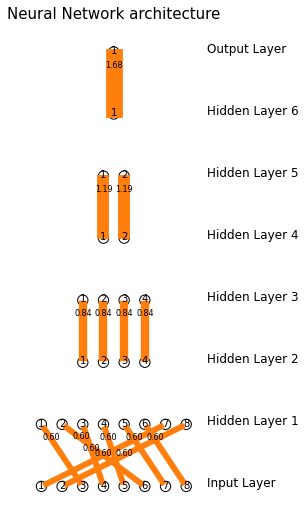

In [ ]:
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 600})')
visualize([8,8,4,2,1], 'weights/ail_xnor_labels_uniform_preinit/ail_xnor_5', 'ail_xnor', 2, bn=False)

###### n=1

XNOR( XNOR( XNOR( 2, 5 ), XNOR( 3, 4 ) ), XNOR( XNOR( 6, 7 ), XNOR( 0, 1 ) ) )

Network with pre-defined weight matrix performance:
val_loss = 0.76898, RMSE =  0.236

================ Layer 0
[[ 0.08691228  0.07540986 -0.06056093 -0.11576639 -0.0081571  -0.22718592
   1.          0.15541612]
 [-0.33079863 -0.1674694  -0.08036961  0.00457281  0.06468256  0.00330098
   0.09154359  1.        ]
 [ 1.         -0.1470187  -0.17132154  0.35203198  0.2867175   0.03831578
  -0.2484823  -0.2917667 ]
 [ 0.26054958 -0.01113301  1.         -0.31508732  0.20960204 -0.09186891
   0.20653017 -0.29011852]
 [-0.01743691  0.29202422  0.14913876  1.         -0.30914047  0.29756603
  -0.14637023  0.22883281]
 [-0.22458366  1.          0.2486876  -0.19288416  0.33037665  0.0347223
   0.0790325   0.19595629]
 [ 0.22338462 -0.00304355 -0.11390518 -0.00730085  1.         -0.2179247
  -0.12465221 -0.24675015]
 [-0.2409998   0.21023577  0.17796557 -0.28013483 -0.1543614   1.
   0.19302493 -0.18494458]]

========

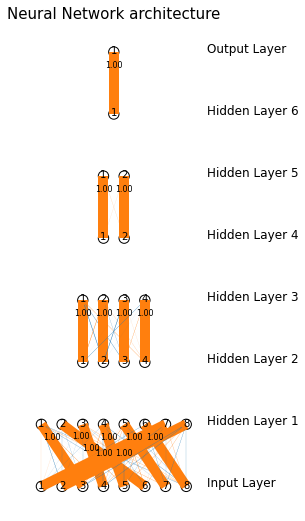

In [ ]:
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 600})')
model = MLP([8,8,4,2,1], 'ail_xnor', bn=False, verbose=False)
print(label_function)
print()
print("Network with pre-defined weight matrix performance:")
new_weight_dict = change_state_dict(model, n=1, p=1.)
evaluate_model(new_weight_dict, nested_val_dataset, bn=False, binary=False)
print()
visualize([8,8,4,2,1], None, 'ail_xnor', 2, state_dict=new_weight_dict, bn=False)

In [ ]:
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 400})')
model = MLP([8,8,4,2,1], 'ail_xnor', bn=False)
model.load_state_dict(new_weight_dict)
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=100, 
            bs=64, max_lr=0.01, output_dir='weights/ail_xnor_labels_uniform_preinit/',
            verbose=True, label='1', binary=False)

========== Model Setup ==========
Activation Function: ail_xnor
p = 1, k = 2, g = 1
ModuleList(
  (0): Linear(in_features=8, out_features=8, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=True)
  )
  (3): Linear(in_features=1, out_features=1, bias=True)
)
Batch norm OFF
Shuffle map 0: size 8
Shuffle map 1: size 4
Shuffle map 2: size 2

--------------
Start training
--------------
Epoch:   1/ 100 | LR = 0.00043 | train_loss = 0.75301, RMSE =  0.224 | val_loss = 0.74006, RMSE =   0.215 | time = 0.652s
  Sample from validation set:
    Input: [-2.1799  0.4424  4.5671  0.3906  1.5489  1.6006  3.6254  0.6116]
    Output: [0.62669843]
    Target: [0.40357283]

Epoch:   2/ 100 | LR = 0.00050 | train_loss = 0.73016, RMSE =  0.205 | val_loss = 0.72232, RMSE =   0.198 | time = 0.656s
  Sample from validation set:
    Input: [ 0.6174 -0.6429  3.365   2.7742 -2.1791  2.8925 -1.3993  

================ Layer 0
[[-4.1107473e-06 -1.3094649e-05 -2.3185087e-06 -2.7328310e-06
  -5.5546025e-06  3.5289322e-06  5.9559482e-01 -1.4973295e-05]
 [-3.9877546e-06  1.9801852e-05 -4.6408759e-06  1.0428269e-05
   1.5187475e-06  3.6874280e-06 -1.5052215e-05  5.9567666e-01]
 [ 5.9556097e-01 -6.2259628e-06 -9.5795767e-06 -1.3641495e-05
  -8.2193010e-06  1.7830485e-05 -4.9174041e-06  7.3791102e-06]
 [ 1.2191771e-05 -3.8293183e-06  5.9576458e-01  1.2388496e-05
  -4.3013197e-06  1.2807164e-05 -1.2257192e-07 -7.1096788e-06]
 [-9.0574067e-06  7.2833736e-06  1.0716201e-05  5.9570140e-01
  -1.3921956e-05 -4.8443553e-07 -4.3427635e-06  2.7950004e-05]
 [-8.6234795e-06  5.9557045e-01 -7.9162610e-06  3.4825908e-07
  -1.9268584e-05  9.0300023e-07  2.7619644e-05 -1.8790204e-06]
 [ 8.3012856e-06  6.3932553e-06 -3.1184186e-06  3.9681481e-06
   5.9552532e-01 -7.8262037e-06 -1.2517595e-05 -1.0625656e-05]
 [ 2.3088955e-05  5.6883541e-06 -1.9733545e-06  5.2660907e-06
  -1.1048982e-05  5.9548277e-01  3.077

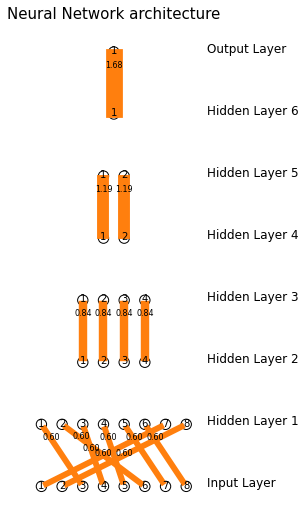

In [ ]:
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 600})')
visualize([8,8,4,2,1], 'weights/ail_xnor_labels_uniform_preinit/ail_xnor_1', 'ail_xnor', 2, bn=False)

###### n=1, adjusting p

================ Layer 0
[[ 0.297385    0.34343258  0.00125935 -0.06936368 -0.22587778 -0.3471817
   0.5        -0.03675095]
 [ 0.07067306 -0.33243462 -0.17920789 -0.15292756  0.18711326  0.0149105
  -0.0201129   0.5       ]
 [ 0.5         0.06628827 -0.25420943 -0.03614881  0.15352571 -0.2816515
  -0.264014    0.21895406]
 [-0.02954279  0.12090637  0.5        -0.11239367  0.29084834 -0.22183011
   0.32747397  0.27228388]
 [ 0.32542878 -0.04978474 -0.30217427  0.5         0.3283115   0.02150084
   0.33776236  0.2648391 ]
 [-0.21769276  0.5         0.11798053 -0.07463077  0.01650125 -0.09225056
  -0.1193989  -0.2507277 ]
 [ 0.3472214  -0.3044453  -0.29032534  0.06094131  0.5        -0.05426023
  -0.09297662  0.08858994]
 [-0.27418348 -0.25351986  0.32065773  0.05977464  0.27321222  0.5
  -0.34061974 -0.1011067 ]]

================ Layer 2
[[ 0.5         0.3799982  -0.00745922  0.2406081 ]
 [-0.22066516  0.5        -0.41976935 -0.02186757]
 [-0.18090993  0.28685498  0.5        -0.2111103

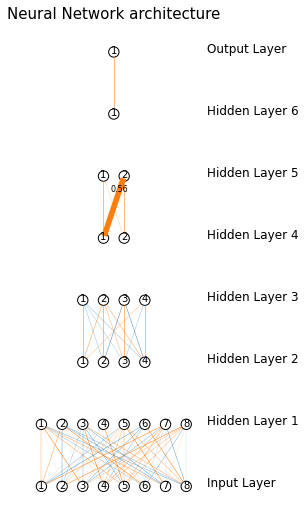

In [ ]:
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 600})')
model = MLP([8,8,4,2,1], 'ail_xnor', bn=False, verbose=False)
new_weight_dict = change_state_dict(model, n=1, p=0.5)
visualize([8,8,4,2,1], None, 'ail_xnor', 2, state_dict=new_weight_dict, bn=False)

In [ ]:
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 400})')
model = MLP([8,8,4,2,1], 'ail_xnor', bn=False)
model.load_state_dict(new_weight_dict)
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=100, 
            bs=64, max_lr=0.01, output_dir='weights/ail_xnor_labels_uniform_preinit/',
            verbose=True, label='1_50', binary=False)

========== Model Setup ==========
Activation Function: ail_xnor
p = 1, k = 2, g = 1
ModuleList(
  (0): Linear(in_features=8, out_features=8, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=True)
  )
  (3): Linear(in_features=1, out_features=1, bias=True)
)
Batch norm OFF
Shuffle map 0: size 8
Shuffle map 1: size 4
Shuffle map 2: size 2

--------------
Start training
--------------
Epoch:   1/ 100 | LR = 0.00043 | train_loss = 0.69414, RMSE =  0.163 | val_loss = 0.69378, RMSE =   0.164 | time = 0.645s
  Sample from validation set:
    Input: [ 0.5975  2.9803  3.3651 -2.0815 -0.7625 -1.9867  0.1139  0.1228]
    Output: [0.50534445]
    Target: [0.4715669]

Epoch:   2/ 100 | LR = 0.00050 | train_loss = 0.69363, RMSE =  0.163 | val_loss = 0.69340, RMSE =   0.164 | time = 0.638s
  Sample from validation set:
    Input: [-2.6932 -3.1631 -0.516   0.901   2.3727 -0.0408 -0.2484 -1

================ Layer 0
[[-1.1772140e-01 -9.6380718e-02 -2.0873304e-01  3.9120618e-01
  -3.3772531e-01 -4.3015242e-01  4.0515396e-01 -4.1974968e-01]
 [ 7.2355402e-01  8.5318297e-02  5.1734060e-01 -6.7613982e-02
  -4.2019397e-01  1.9935340e-02 -2.8520545e-01  4.5811176e-01]
 [-5.5538576e-02 -4.5983680e-02  5.0175107e-01  3.1988552e-01
  -2.9162139e-01 -2.8558621e-01  3.7976813e-01 -4.7807729e-01]
 [-6.8908170e-02 -4.6177965e-02  5.3197324e-01  3.0487967e-01
  -2.6921824e-01 -3.0228928e-01  4.5120862e-01 -3.9863312e-01]
 [-2.6999872e-02 -1.5965942e-04  4.2841560e-01  3.1111982e-01
  -3.5017624e-01 -3.5484588e-01  3.7554243e-01 -4.2431343e-01]
 [-6.2682249e-02  1.0813998e+00  6.2143075e-01  4.1838650e-02
  -5.5799328e-02 -9.2468068e-02 -3.4850675e-01 -4.5171654e-01]
 [ 1.1109756e-01 -8.3675697e-02 -5.7633615e-01 -2.9441610e-01
   7.3652226e-01 -3.6984307e-01 -2.9645422e-01 -4.9982259e-01]
 [ 4.6645802e-02 -8.5471347e-03  5.6562573e-01  2.7005282e-01
  -4.1943201e-01  7.8501993e-01  3.472

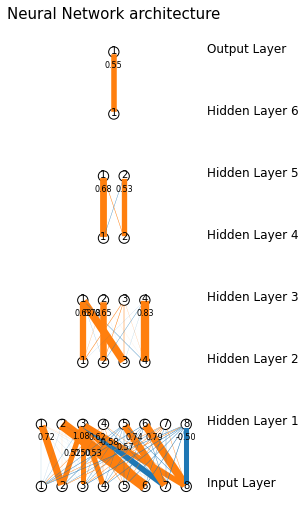

In [ ]:
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 600})')
visualize([8,8,4,2,1], 'weights/ail_xnor_labels_uniform_preinit/ail_xnor_1_50', 'ail_xnor', 2, bn=False)

================ Layer 0
[[ 0.2956914   0.19563125  0.06869569  0.2568338   0.23443775  0.01716789
   0.75       -0.31633717]
 [ 0.01248807 -0.05879886 -0.34391946 -0.2992356  -0.25719896 -0.12094704
   0.06119086  0.75      ]
 [ 0.75       -0.26943687  0.19531465 -0.17137398  0.09155539  0.23909275
  -0.06915522 -0.12965938]
 [ 0.22142626  0.2497344   0.75        0.08364999 -0.28335556 -0.14558537
  -0.09111175 -0.33079806]
 [ 0.25383857 -0.30747163  0.30526805  0.75        0.05519307  0.03658975
   0.2952676   0.08515644]
 [ 0.12679617  0.75        0.17705533  0.1550177  -0.08638747 -0.12720875
   0.23995541 -0.02914387]
 [-0.1475216   0.15433489 -0.16368516 -0.2824717   0.75        0.13389374
  -0.11833065 -0.23268676]
 [-0.24407096 -0.26782063 -0.20605923 -0.34358457 -0.08699623  0.75
   0.2250938   0.34537712]]

================ Layer 2
[[ 0.75        0.31692964  0.27399725  0.3514651 ]
 [ 0.2420677   0.75        0.19943208  0.34583306]
 [-0.25398523  0.35592878  0.75        0.198

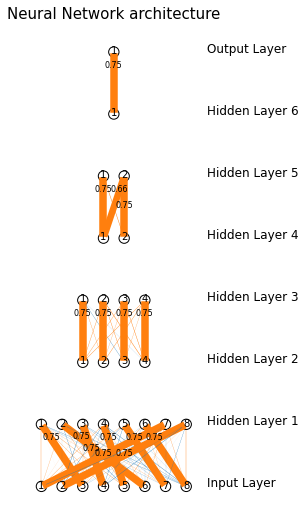

In [ ]:
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 600})')
model = MLP([8,8,4,2,1], 'ail_xnor', bn=False, verbose=False)
new_weight_dict = change_state_dict(model, n=1, p=0.75)
visualize([8,8,4,2,1], None, 'ail_xnor', 2, state_dict=new_weight_dict, bn=False)

In [ ]:
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 400})')
model = MLP([8,8,4,2,1], 'ail_xnor', bn=False)
model.load_state_dict(new_weight_dict)
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=100, 
            bs=64, max_lr=0.01, output_dir='weights/ail_xnor_labels_uniform_preinit/',
            verbose=True, label='1_75', binary=False)

========== Model Setup ==========
Activation Function: ail_xnor
p = 1, k = 2, g = 1
ModuleList(
  (0): Linear(in_features=8, out_features=8, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=True)
  )
  (3): Linear(in_features=1, out_features=1, bias=True)
)
Batch norm OFF
Shuffle map 0: size 8
Shuffle map 1: size 4
Shuffle map 2: size 2

--------------
Start training
--------------
Epoch:   1/ 100 | LR = 0.00043 | train_loss = 0.72684, RMSE =  0.201 | val_loss = 0.71001, RMSE =   0.185 | time = 0.639s
  Sample from validation set:
    Input: [-4.1865 -4.8495 -1.4515 -4.6207 -4.0393 -0.2435 -2.8204 -0.3437]
    Output: [0.57256365]
    Target: [0.56056476]

Epoch:   2/ 100 | LR = 0.00050 | train_loss = 0.70448, RMSE =  0.177 | val_loss = 0.69955, RMSE =   0.172 | time = 0.652s
  Sample from validation set:
    Input: [-2.1009 -1.7042 -0.9161 -2.1607  4.5484 -3.8676  0.8312  

================ Layer 0
[[ 4.3351869e-05 -3.1191842e-06  4.0727737e-05 -3.2839456e-05
   2.2203880e-05 -1.8681347e-05  5.9559470e-01  5.1504110e-05]
 [ 1.6393798e-05 -1.0084468e-05  3.9406645e-05  1.8275716e-05
   6.5398222e-06 -5.0567605e-06 -4.6532728e-05  5.9572947e-01]
 [ 5.9554213e-01 -5.8870528e-06 -1.7243279e-05 -3.9697599e-05
  -4.1374726e-05  5.2530489e-05  1.4765942e-05  1.3360986e-05]
 [-3.8494971e-05 -1.0645801e-05  5.9548330e-01 -4.9104997e-06
   1.1702049e-05  2.5541203e-05  1.7245298e-05 -4.2077492e-05]
 [ 1.3530505e-06 -1.1824625e-05  7.9858501e-06  5.9540439e-01
  -2.5720781e-05  5.2787651e-05 -3.2202053e-05  4.2266103e-05]
 [-7.7473942e-06  5.9541309e-01  1.6298227e-05  2.6492922e-05
  -1.5437301e-05  2.9778026e-05 -2.6737072e-05 -9.7438069e-06]
 [ 3.8048756e-06  2.6689720e-05 -6.5661770e-05  6.5566193e-05
   5.9534174e-01 -2.4106237e-05 -4.3359298e-05 -1.7988934e-05]
 [-4.3334141e-05 -1.3308011e-07 -3.5542614e-06  2.3841016e-05
  -1.9187779e-05  5.9542131e-01  1.215

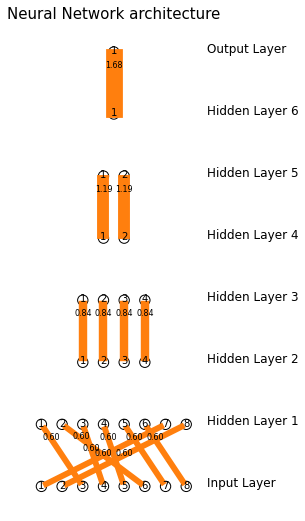

In [ ]:
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 600})')
visualize([8,8,4,2,1], 'weights/ail_xnor_labels_uniform_preinit/ail_xnor_1_75', 'ail_xnor', 2, bn=False)

================ Layer 0
[[-0.2380698   0.16563682  0.34042615  0.05981797  0.22234869 -0.16081057
   0.6        -0.05257664]
 [-0.18878147 -0.00492102 -0.30644563 -0.32939276  0.14004968  0.07808045
   0.07326943  0.6       ]
 [ 0.6         0.21477477 -0.19347367  0.19521555 -0.3532618   0.06509425
  -0.11497091  0.18629336]
 [ 0.21352032 -0.21114846  0.6         0.2624038   0.12576708  0.02380623
  -0.23662458 -0.2931727 ]
 [ 0.12079017  0.08921185 -0.03325854  0.6         0.31110534 -0.23903964
   0.29109102 -0.13161613]
 [ 0.02316176  0.6         0.21157287 -0.23663512  0.31435674  0.13224876
   0.08276515  0.31329867]
 [ 0.00162662 -0.25776052  0.01576048 -0.02957946  0.6        -0.11703914
   0.32264525 -0.32772368]
 [ 0.2651938  -0.1450957   0.11001726  0.30914697 -0.12743403  0.6
  -0.09483774  0.04258939]]

================ Layer 2
[[ 0.6         0.05976063  0.34295154  0.3642944 ]
 [ 0.4502759   0.6        -0.2420063   0.4359687 ]
 [ 0.00944173 -0.47841632  0.6        -0.4151

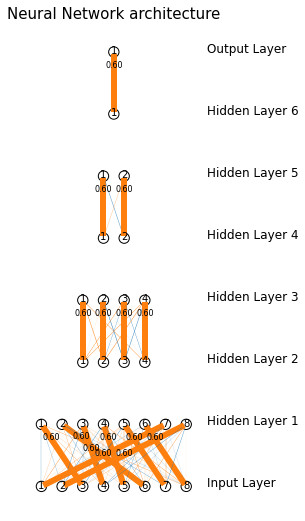

In [ ]:
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 600})')
model = MLP([8,8,4,2,1], 'ail_xnor', bn=False, verbose=False)
new_weight_dict = change_state_dict(model, n=1, p=0.6)
visualize([8,8,4,2,1], None, 'ail_xnor', 2, state_dict=new_weight_dict, bn=False)

In [ ]:
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 400})')
model = MLP([8,8,4,2,1], 'ail_xnor', bn=False)
model.load_state_dict(new_weight_dict)
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=100, 
            bs=64, max_lr=0.01, output_dir='weights/ail_xnor_labels_uniform_preinit/',
            verbose=True, label='1_60', binary=False)

========== Model Setup ==========
Activation Function: ail_xnor
p = 1, k = 2, g = 1
ModuleList(
  (0): Linear(in_features=8, out_features=8, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=True)
  )
  (3): Linear(in_features=1, out_features=1, bias=True)
)
Batch norm OFF
Shuffle map 0: size 8
Shuffle map 1: size 4
Shuffle map 2: size 2

--------------
Start training
--------------
Epoch:   1/ 100 | LR = 0.00043 | train_loss = 0.69717, RMSE =  0.168 | val_loss = 0.69587, RMSE =   0.167 | time = 0.647s
  Sample from validation set:
    Input: [ 4.1965 -0.5101  1.9627  3.6704 -3.3063  4.6513  2.2797  4.1532]
    Output: [0.52986443]
    Target: [0.6248268]

Epoch:   2/ 100 | LR = 0.00050 | train_loss = 0.69511, RMSE =  0.165 | val_loss = 0.69457, RMSE =   0.165 | time = 0.621s
  Sample from validation set:
    Input: [-4.166   2.2244  4.4291 -3.2365 -1.2197 -1.6918 -3.8869  3

================ Layer 0
[[ 1.43519994e-02 -1.23120956e-02  1.65732145e-01  7.50901876e-03
  -8.67633522e-02 -9.23823953e-01  5.07204592e-01 -4.77580279e-02]
 [ 3.62901902e-03 -1.03338081e-02  8.47493857e-03 -5.81223704e-03
   9.74097103e-02 -9.01081711e-02 -3.38090099e-02  1.22820449e+00]
 [-5.52728726e-03 -5.50958684e-05 -1.46029711e-01  5.04928231e-02
  -6.46129966e-01  4.41779882e-01 -5.18446565e-01  3.79119813e-02]
 [ 8.92595053e-01  2.90683284e-02  2.75965570e-03  3.19121219e-02
  -7.30119087e-03  1.79889090e-02 -1.07076159e-02 -1.05190948e-02]
 [-3.33375903e-03  4.69984347e-03 -2.75730323e-02  1.72374904e+00
   1.99829489e-01 -9.37407315e-02  5.00929236e-01 -5.25999926e-02]
 [ 8.82809423e-03  8.74218702e-01 -1.26649328e-02 -1.14308335e-02
  -8.75584595e-03  9.32499953e-03 -8.26417096e-03  8.55407398e-03]
 [ 3.81189166e-03  2.28239503e-03  1.40504614e-01 -4.28451411e-02
   6.56196177e-01 -4.52807218e-01  5.17712176e-01 -4.15446907e-02]
 [-2.39370996e-03 -3.41952126e-03 -1.6511859

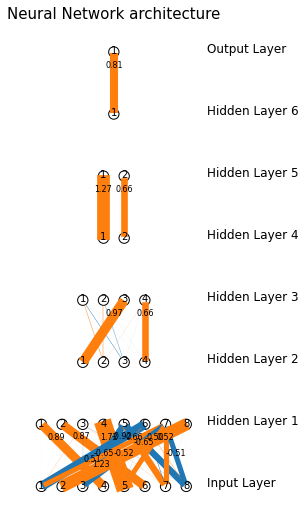

In [ ]:
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 600})')
visualize([8,8,4,2,1], 'weights/ail_xnor_labels_uniform_preinit/ail_xnor_1_60', 'ail_xnor', 2, bn=False)

================ Layer 0
[[-0.14437804 -0.0336744   0.21294792 -0.30099118  0.05977612  0.17861037
   0.7        -0.35016474]
 [-0.26187983  0.09380392  0.17179123 -0.05420864 -0.27370462 -0.16968979
  -0.3253826   0.7       ]
 [ 0.7        -0.14361054 -0.28147483  0.25983208 -0.2937418   0.04217825
  -0.00075704  0.17135969]
 [-0.1853867   0.25585973  0.7        -0.01410204  0.15287332  0.25683728
   0.25676012  0.08058785]
 [-0.3162242   0.1893869  -0.19736534  0.7        -0.3411793   0.00634816
  -0.2342387  -0.13182472]
 [-0.08604654  0.7         0.0494321   0.02374271  0.35310346  0.23057356
  -0.10112386 -0.06734784]
 [ 0.18472496  0.05243405 -0.12119318 -0.26155144  0.7         0.03607602
   0.16668037  0.09048667]
 [-0.08861998 -0.15024272  0.15072784 -0.00958853  0.31559753  0.7
   0.23085022 -0.01729197]]

================ Layer 2
[[ 0.7        -0.09502053  0.37944227  0.11509126]
 [-0.13297641  0.7        -0.48636907  0.23557365]
 [ 0.15206349  0.04532564  0.7        -0.3406

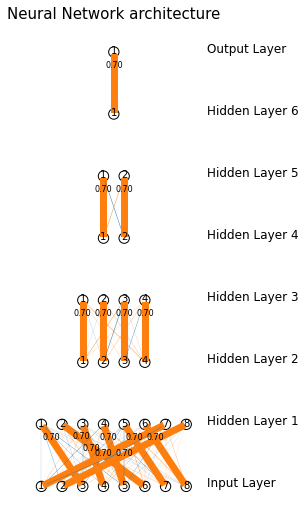

In [ ]:
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 600})')
model = MLP([8,8,4,2,1], 'ail_xnor', bn=False, verbose=False)
new_weight_dict = change_state_dict(model, n=1, p=0.70)
visualize([8,8,4,2,1], None, 'ail_xnor', 2, state_dict=new_weight_dict, bn=False)

In [ ]:
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 400})')
model = MLP([8,8,4,2,1], 'ail_xnor', bn=False)
model.load_state_dict(new_weight_dict)
train_model(model, [nested_train_dataset, nested_val_dataset], num_epochs=100, 
            bs=64, max_lr=0.01, output_dir='weights/ail_xnor_labels_uniform_preinit/',
            verbose=True, label='1_70', binary=False)

========== Model Setup ==========
Activation Function: ail_xnor
p = 1, k = 2, g = 1
ModuleList(
  (0): Linear(in_features=8, out_features=8, bias=True)
  (1): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
  )
  (2): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=True)
  )
  (3): Linear(in_features=1, out_features=1, bias=True)
)
Batch norm OFF
Shuffle map 0: size 8
Shuffle map 1: size 4
Shuffle map 2: size 2

--------------
Start training
--------------
Epoch:   1/ 100 | LR = 0.00043 | train_loss = 0.70302, RMSE =  0.176 | val_loss = 0.69941, RMSE =   0.172 | time = 0.656s
  Sample from validation set:
    Input: [-4.3458  0.0656 -2.9919  4.0023 -2.6159 -4.0622 -3.2401 -4.1774]
    Output: [0.51575524]
    Target: [0.51640457]

Epoch:   2/ 100 | LR = 0.00050 | train_loss = 0.69825, RMSE =  0.169 | val_loss = 0.69661, RMSE =   0.168 | time = 0.622s
  Sample from validation set:
    Input: [-2.5087 -2.3603 -4.5324 -3.4873 -1.1676 -3.3213 -3.4811 -

================ Layer 0
[[-1.46822122e-05 -1.25461838e-05  4.86583449e-05 -2.56731819e-05
   5.90968739e-06 -6.03281387e-06  5.95701516e-01 -2.07220364e-05]
 [-2.43759314e-05  4.75384331e-05 -3.65619780e-05 -6.09870858e-06
  -1.97281370e-05 -4.65458379e-06 -1.77053680e-05  5.95553339e-01]
 [ 5.95648110e-01 -2.13308831e-05  8.59626743e-06 -5.04856944e-05
  -9.72525686e-06  5.16522741e-05 -1.78186274e-05  1.52521652e-05]
 [-5.82199318e-05  2.20621041e-05  5.95496953e-01  4.08423512e-05
   1.32668220e-05  7.52499182e-05  2.67162395e-05 -7.47525792e-06]
 [ 3.02712924e-05  7.34345167e-06 -1.46860311e-05  5.95366061e-01
   1.88987963e-06  1.75858459e-05  2.31313315e-05 -8.43690214e-06]
 [ 1.44555488e-05  5.95447779e-01  3.00820793e-05  9.16078989e-06
   3.33814714e-05 -3.69717272e-05  8.21315643e-06  4.87161685e-07]
 [ 5.63506692e-05 -1.39763979e-05 -2.14082902e-05 -1.66712980e-05
   5.95760286e-01  4.30047075e-05 -3.62371611e-05 -1.39419035e-05]
 [ 2.19805152e-05  8.48552590e-05 -2.4816034

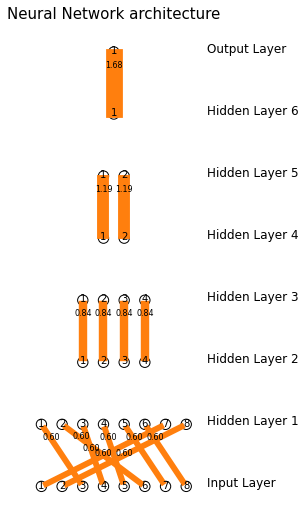

In [ ]:
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 600})')
visualize([8,8,4,2,1], 'weights/ail_xnor_labels_uniform_preinit/ail_xnor_1_70', 'ail_xnor', 2, bn=False)